In [ ]:
!pip install -q yfinance

In [1]:
# import libraries

import sys
import random
import time
import os
import pickle

import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, \
                            roc_auc_score, confusion_matrix
from sklearn.metrics import f1_score as f1_sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Input, SimpleRNN, GRU, Dropout
from keras.models import Sequential

from keras import backend as K

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime
import sys
import io

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')
import seaborn as sns
from IPython.display import display, Markdown

# To avoid non-essential warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU devices found. Training on CPU.")

Default GPU Device: /device:GPU:0


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
#The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
# #Download the code.
# !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
# !mv download FLOPs_counter.py

In [ ]:
# from FLOPs_counter import print_model_parm_flops

In [ ]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 12, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end, interval='1d')


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
for index, (company, com_name) in enumerate(zip(company_list, company_name)):
    company["company_name"] = com_name
    company["ticker_id"] = tech_list[index]

tech_stock = pd.concat(company_list, axis=0)
tech_stock.head(5)

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2011-11-23  13.375357  13.422857  13.102857  13.106786  11.110357  428271200   
2011-11-25  13.157857  13.255357  12.975714  12.984643  11.006821  254760800   
2011-11-28  13.298214  13.454286  13.226071  13.432857  11.386761  346413200   
2011-11-29  13.422857  13.529643  13.221429  13.328571  11.298358  375855200   
2011-11-30  13.617500  13.652857  13.510714  13.650000  11.570828  405938400   

           company_name ticker_id  
Date                               
2011-11-23        APPLE      AAPL  
2011-11-25        APPLE      AAPL  
2011-11-28        APPLE      AAPL  
2011-11-29        APPLE      AAPL  
2011-11-30        APPLE      AAPL

In [ ]:
len(tech_stock)

12076

In [ ]:
for symbol in tech_list:
    stock_data = yf.Ticker(symbol)
    stock_info = stock_data.history(period="5y")

    # Print the heading with the stock symbol
    print(f"Summary Stats for {symbol}:")

    # Calculate and print the describe().T statistics
    display(stock_info.describe().T)
    print()  # Add an empty line for separation between stocks

Summary Stats for AAPL:


count          mean           std           min           25%  \
Open          1258.0  1.184022e+02  4.700001e+01  3.454840e+01  6.990103e+01   
High          1258.0  1.197882e+02  4.746596e+01  3.496591e+01  7.134727e+01   
Low           1258.0  1.171241e+02  4.656464e+01  3.407329e+01  6.937263e+01   
Close         1258.0  1.185224e+02  4.703023e+01  3.411888e+01  7.057509e+01   
Volume        1258.0  1.042038e+08  5.374405e+07  3.145820e+07  6.946008e+07   
Dividends     1258.0  3.412162e-03  2.695033e-02  0.000000e+00  0.000000e+00   
Stock Splits  1258.0  3.179650e-03  1.127768e-01  0.000000e+00  0.000000e+00   

                       50%           75%           max  
Open          1.309365e+02  1.550979e+02  1.957175e+02  
High          1.324600e+02  1.571221e+02  1.977022e+02  
Low           1.293782e+02  1.528526e+02  1.947601e+02  
Close         1.310348e+02  1.552144e+02  1.959270e+02  
Volume        8.995340e+07  1.225690e+08  4.265100e+08  
Dividends     0.000000e+00  0.000000e+00  2.400000e-01  
Stock Splits  0.000000e+00  0.000000e+00  4.000000e+00


Summary Stats for GOOG:


count          mean           std           min           25%  \
Open          1258.0  9.693084e+01  3.032630e+01  4.869500e+01  6.750000e+01   
High          1258.0  9.806568e+01  3.061170e+01  5.017700e+01  6.800550e+01   
Low           1258.0  9.591896e+01  3.001621e+01  4.850550e+01  6.696875e+01   
Close         1258.0  9.701535e+01  3.030287e+01  4.881100e+01  6.744813e+01   
Volume        1258.0  2.948496e+07  1.297594e+07  6.936000e+06  2.115550e+07   
Dividends     1258.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Stock Splits  1258.0  1.589825e-02  5.638839e-01  0.000000e+00  0.000000e+00   

                       50%           75%           max  
Open          9.779500e+01  1.245800e+02  1.518635e+02  
High          9.948700e+01  1.258450e+02  1.521000e+02  
Low           9.663000e+01  1.232525e+02  1.498875e+02  
Close         9.800000e+01  1.243775e+02  1.507090e+02  
Volume        2.638530e+07  3.347150e+07  1.241400e+08  
Dividends     0.000000e+00  0.000000e+00  0.000000e+00  
Stock Splits  0.000000e+00  0.000000e+00  2.000000e+01


Summary Stats for MSFT:


count          mean           std           min           25%  \
Open          1258.0  2.262447e+02  7.287449e+01  9.034469e+01  1.590384e+02   
High          1258.0  2.286305e+02  7.354728e+01  9.303204e+01  1.609250e+02   
Low           1258.0  2.238090e+02  7.217027e+01  8.922416e+01  1.569116e+02   
Close         1258.0  2.263276e+02  7.287003e+01  8.938558e+01  1.594727e+02   
Volume        1258.0  2.983017e+07  1.266460e+07  8.989200e+06  2.183128e+07   
Dividends     1258.0  9.228935e-03  7.339994e-02  0.000000e+00  0.000000e+00   
Stock Splits  1258.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                       50%           75%           max  
Open          2.360674e+02  2.840364e+02  3.780000e+02  
High          2.387655e+02  2.870051e+02  3.797900e+02  
Low           2.339204e+02  2.810557e+02  3.749700e+02  
Close         2.372434e+02  2.842188e+02  3.778500e+02  
Volume        2.666920e+07  3.375020e+07  1.112421e+08  
Dividends     0.000000e+00  0.000000e+00  7.500000e-01  
Stock Splits  0.000000e+00  0.000000e+00  0.000000e+00


Summary Stats for AMZN:


count          mean           std           min           25%  \
Open          1258.0  1.262853e+02  3.188181e+01  6.730000e+01  9.458237e+01   
High          1258.0  1.278483e+02  3.216633e+01  6.980150e+01  9.565888e+01   
Low           1258.0  1.246136e+02  3.150821e+01  6.535000e+01  9.348125e+01   
Close         1258.0  1.262478e+02  3.179433e+01  6.719800e+01  9.462037e+01   
Volume        1258.0  7.788221e+07  3.531185e+07  1.762600e+07  5.428785e+07   
Dividends     1258.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Stock Splits  1258.0  1.589825e-02  5.638839e-01  0.000000e+00  0.000000e+00   

                       50%           75%           max  
Open          1.247750e+02  1.583469e+02  1.872000e+02  
High          1.264450e+02  1.599308e+02  1.886540e+02  
Low           1.231243e+02  1.562250e+02  1.848395e+02  
Close         1.248100e+02  1.580937e+02  1.865705e+02  
Volume        6.707655e+07  9.219150e+07  3.113460e+08  
Dividends     0.000000e+00  0.000000e+00  0.000000e+00  
Stock Splits  0.000000e+00  0.000000e+00  2.000000e+01

In [ ]:
for symbol in tech_list:
    stock_data = yf.Ticker(symbol)
    stock_info = stock_data.history(period="5y")

    # Print the heading with the stock symbol
    print(f"Summary Stats for {symbol}:")

    # concise summary of the DataFrame
    info_dict = {
        'Column Name': stock_info.columns,
        'Data Type': stock_info.dtypes,
        'Non-Null Count': stock_info.count(),
        'Null Count': stock_info.isnull().sum(),
        'Unique Count': stock_info.nunique()
    }

    # Create a new DataFrame
    info_df = pd.DataFrame(info_dict)
    # Set numerical numbers as the index
    info_df.index = range(1, len(info_df) + 1)
    # Calculate and print the describe().T statistics
    display(info_df)
    print()  # Add an empty line for separation between stocks

Summary Stats for AAPL:


Column Name Data Type  Non-Null Count  Null Count  Unique Count
1          Open   float64            1258           0          1258
2          High   float64            1258           0          1258
3           Low   float64            1258           0          1258
4         Close   float64            1258           0          1245
5        Volume     int64            1258           0          1255
6     Dividends   float64            1258           0             7
7  Stock Splits   float64            1258           0             2


Summary Stats for GOOG:


Column Name Data Type  Non-Null Count  Null Count  Unique Count
1          Open   float64            1258           0          1233
2          High   float64            1258           0          1246
3           Low   float64            1258           0          1244
4         Close   float64            1258           0          1241
5        Volume     int64            1258           0          1241
6     Dividends   float64            1258           0             1
7  Stock Splits   float64            1258           0             2


Summary Stats for MSFT:


Column Name Data Type  Non-Null Count  Null Count  Unique Count
1          Open   float64            1258           0          1258
2          High   float64            1258           0          1257
3           Low   float64            1258           0          1258
4         Close   float64            1258           0          1243
5        Volume     int64            1258           0          1252
6     Dividends   float64            1258           0             7
7  Stock Splits   float64            1258           0             1


Summary Stats for AMZN:


Column Name Data Type  Non-Null Count  Null Count  Unique Count
1          Open   float64            1258           0          1201
2          High   float64            1258           0          1225
3           Low   float64            1258           0          1224
4         Close   float64            1258           0          1234
5        Volume     int64            1258           0          1250
6     Dividends   float64            1258           0             1
7  Stock Splits   float64            1258           0             2

In [ ]:
# removed the missing values
tech_stock = tech_stock.dropna()

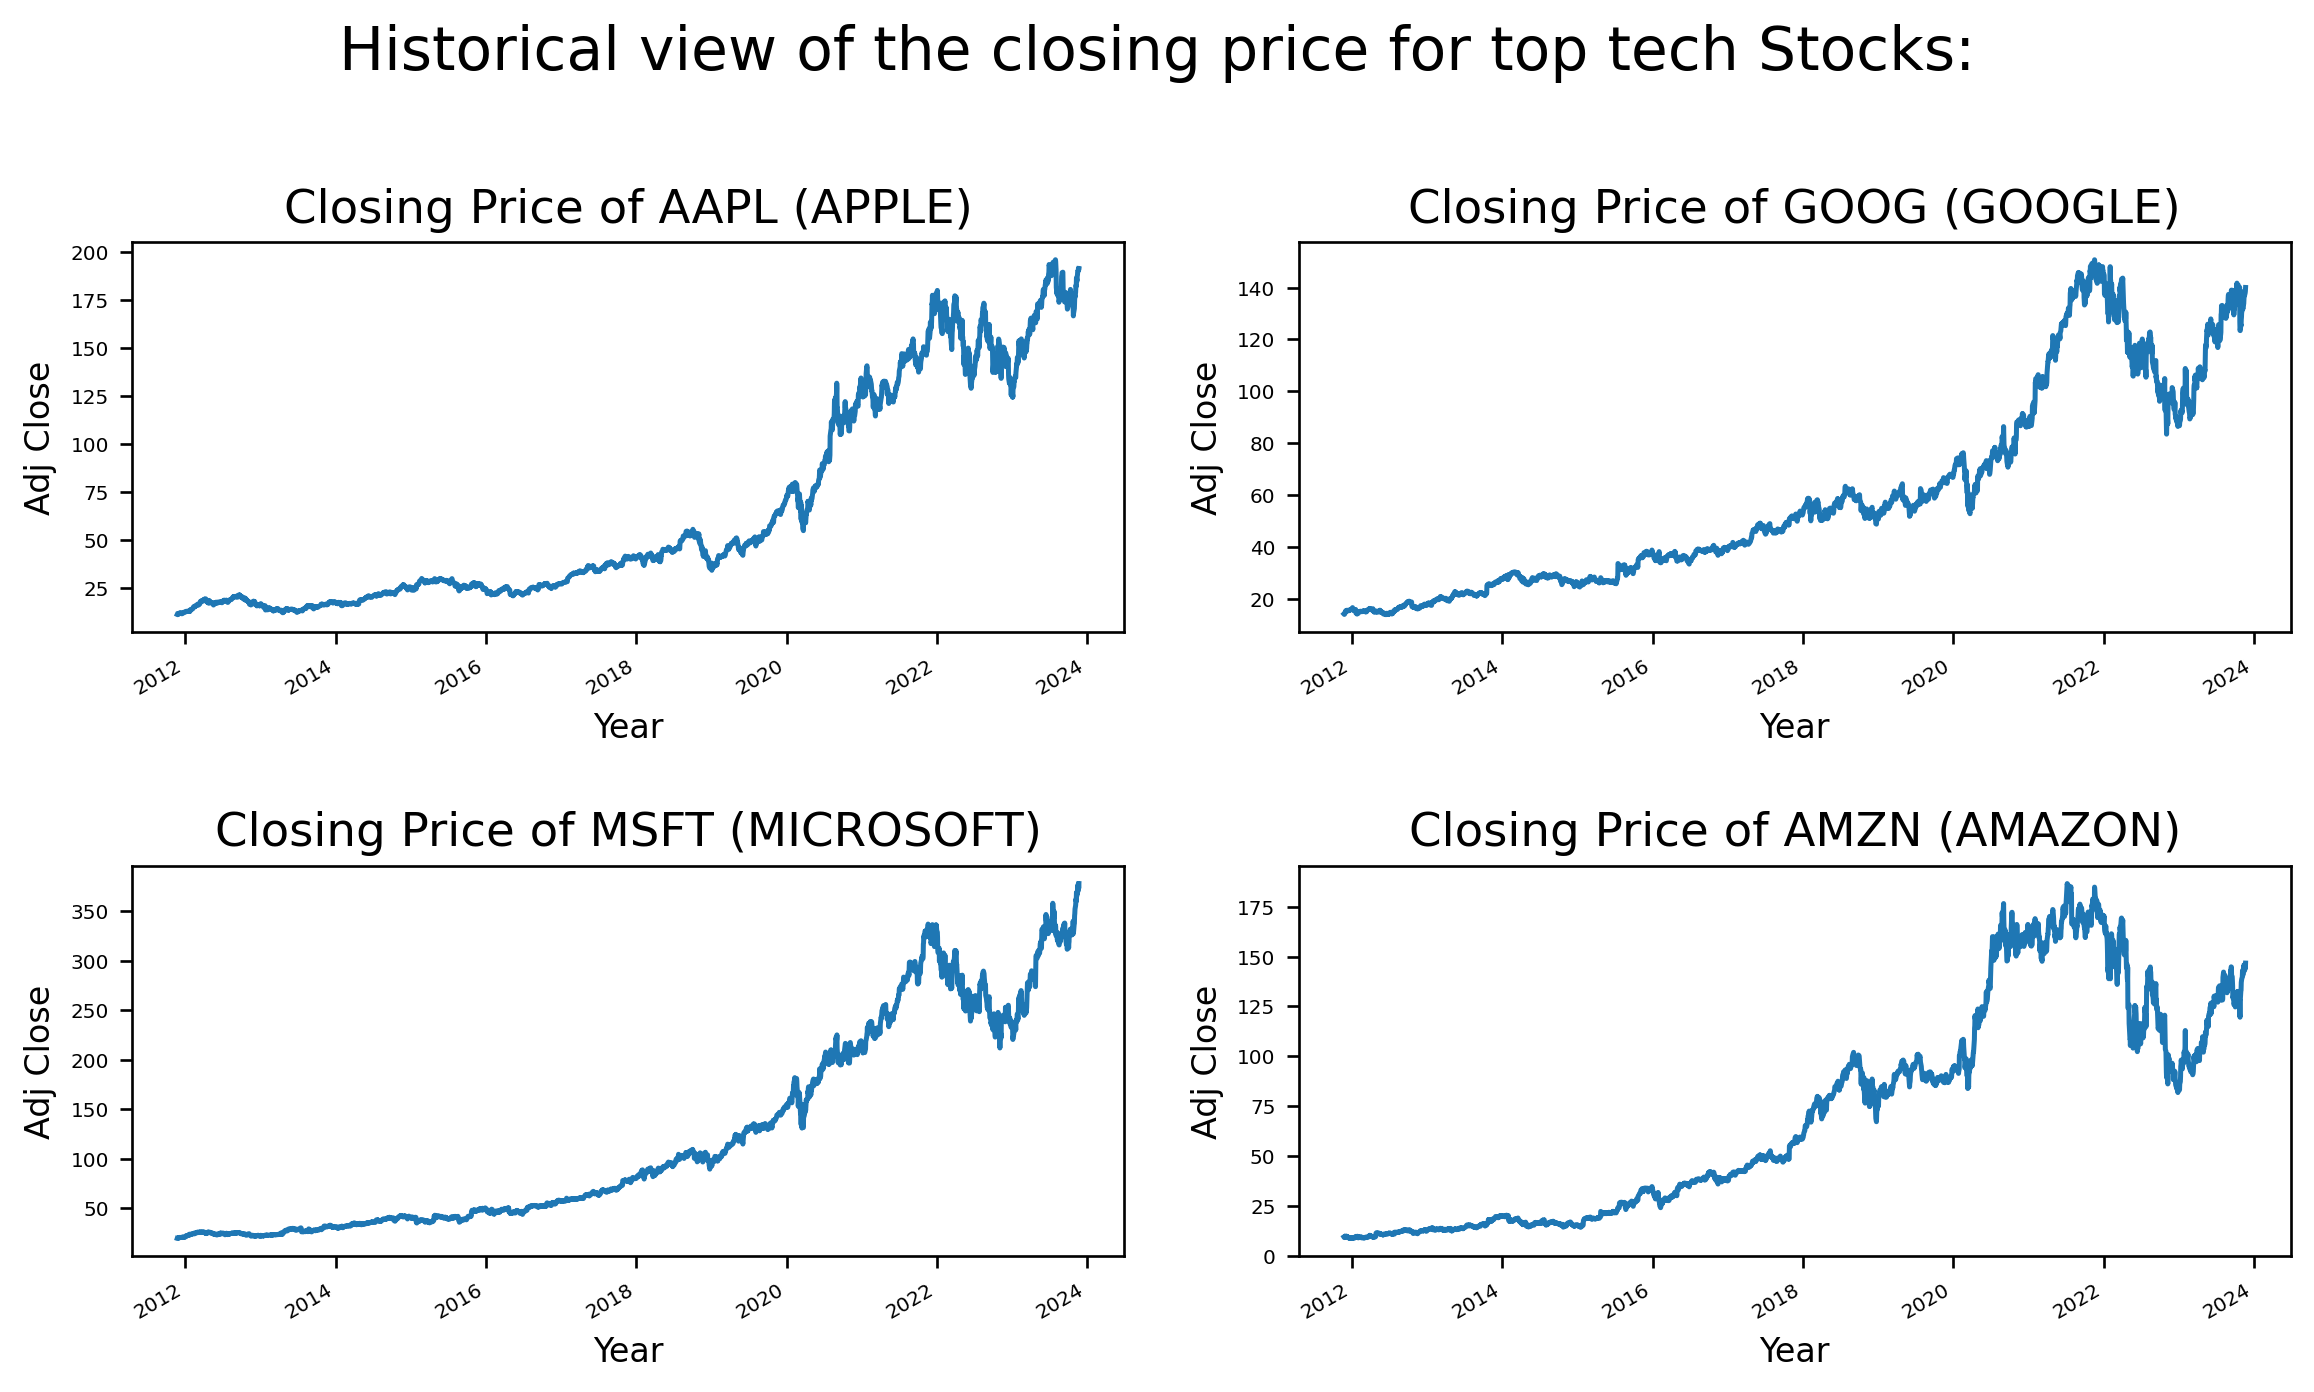

In [ ]:
# Let's see a historical view of the closing price
plt.figure(figsize=(10, 6))
plt.subplots_adjust(top=1.51, bottom=1.5)

plt.suptitle(f'Historical view of the closing price for top tech Stocks:', fontsize=18)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close', fontsize=10)
    plt.xlabel('Year', fontsize=10)
    plt.title(f"Closing Price of {tech_list[i - 1]} ({company_name[i - 1]})", fontsize=14)

# Adjust layout
plt.subplots_adjust(hspace=1, wspace=0.6)
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
ma_day = [7, 30, 90]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

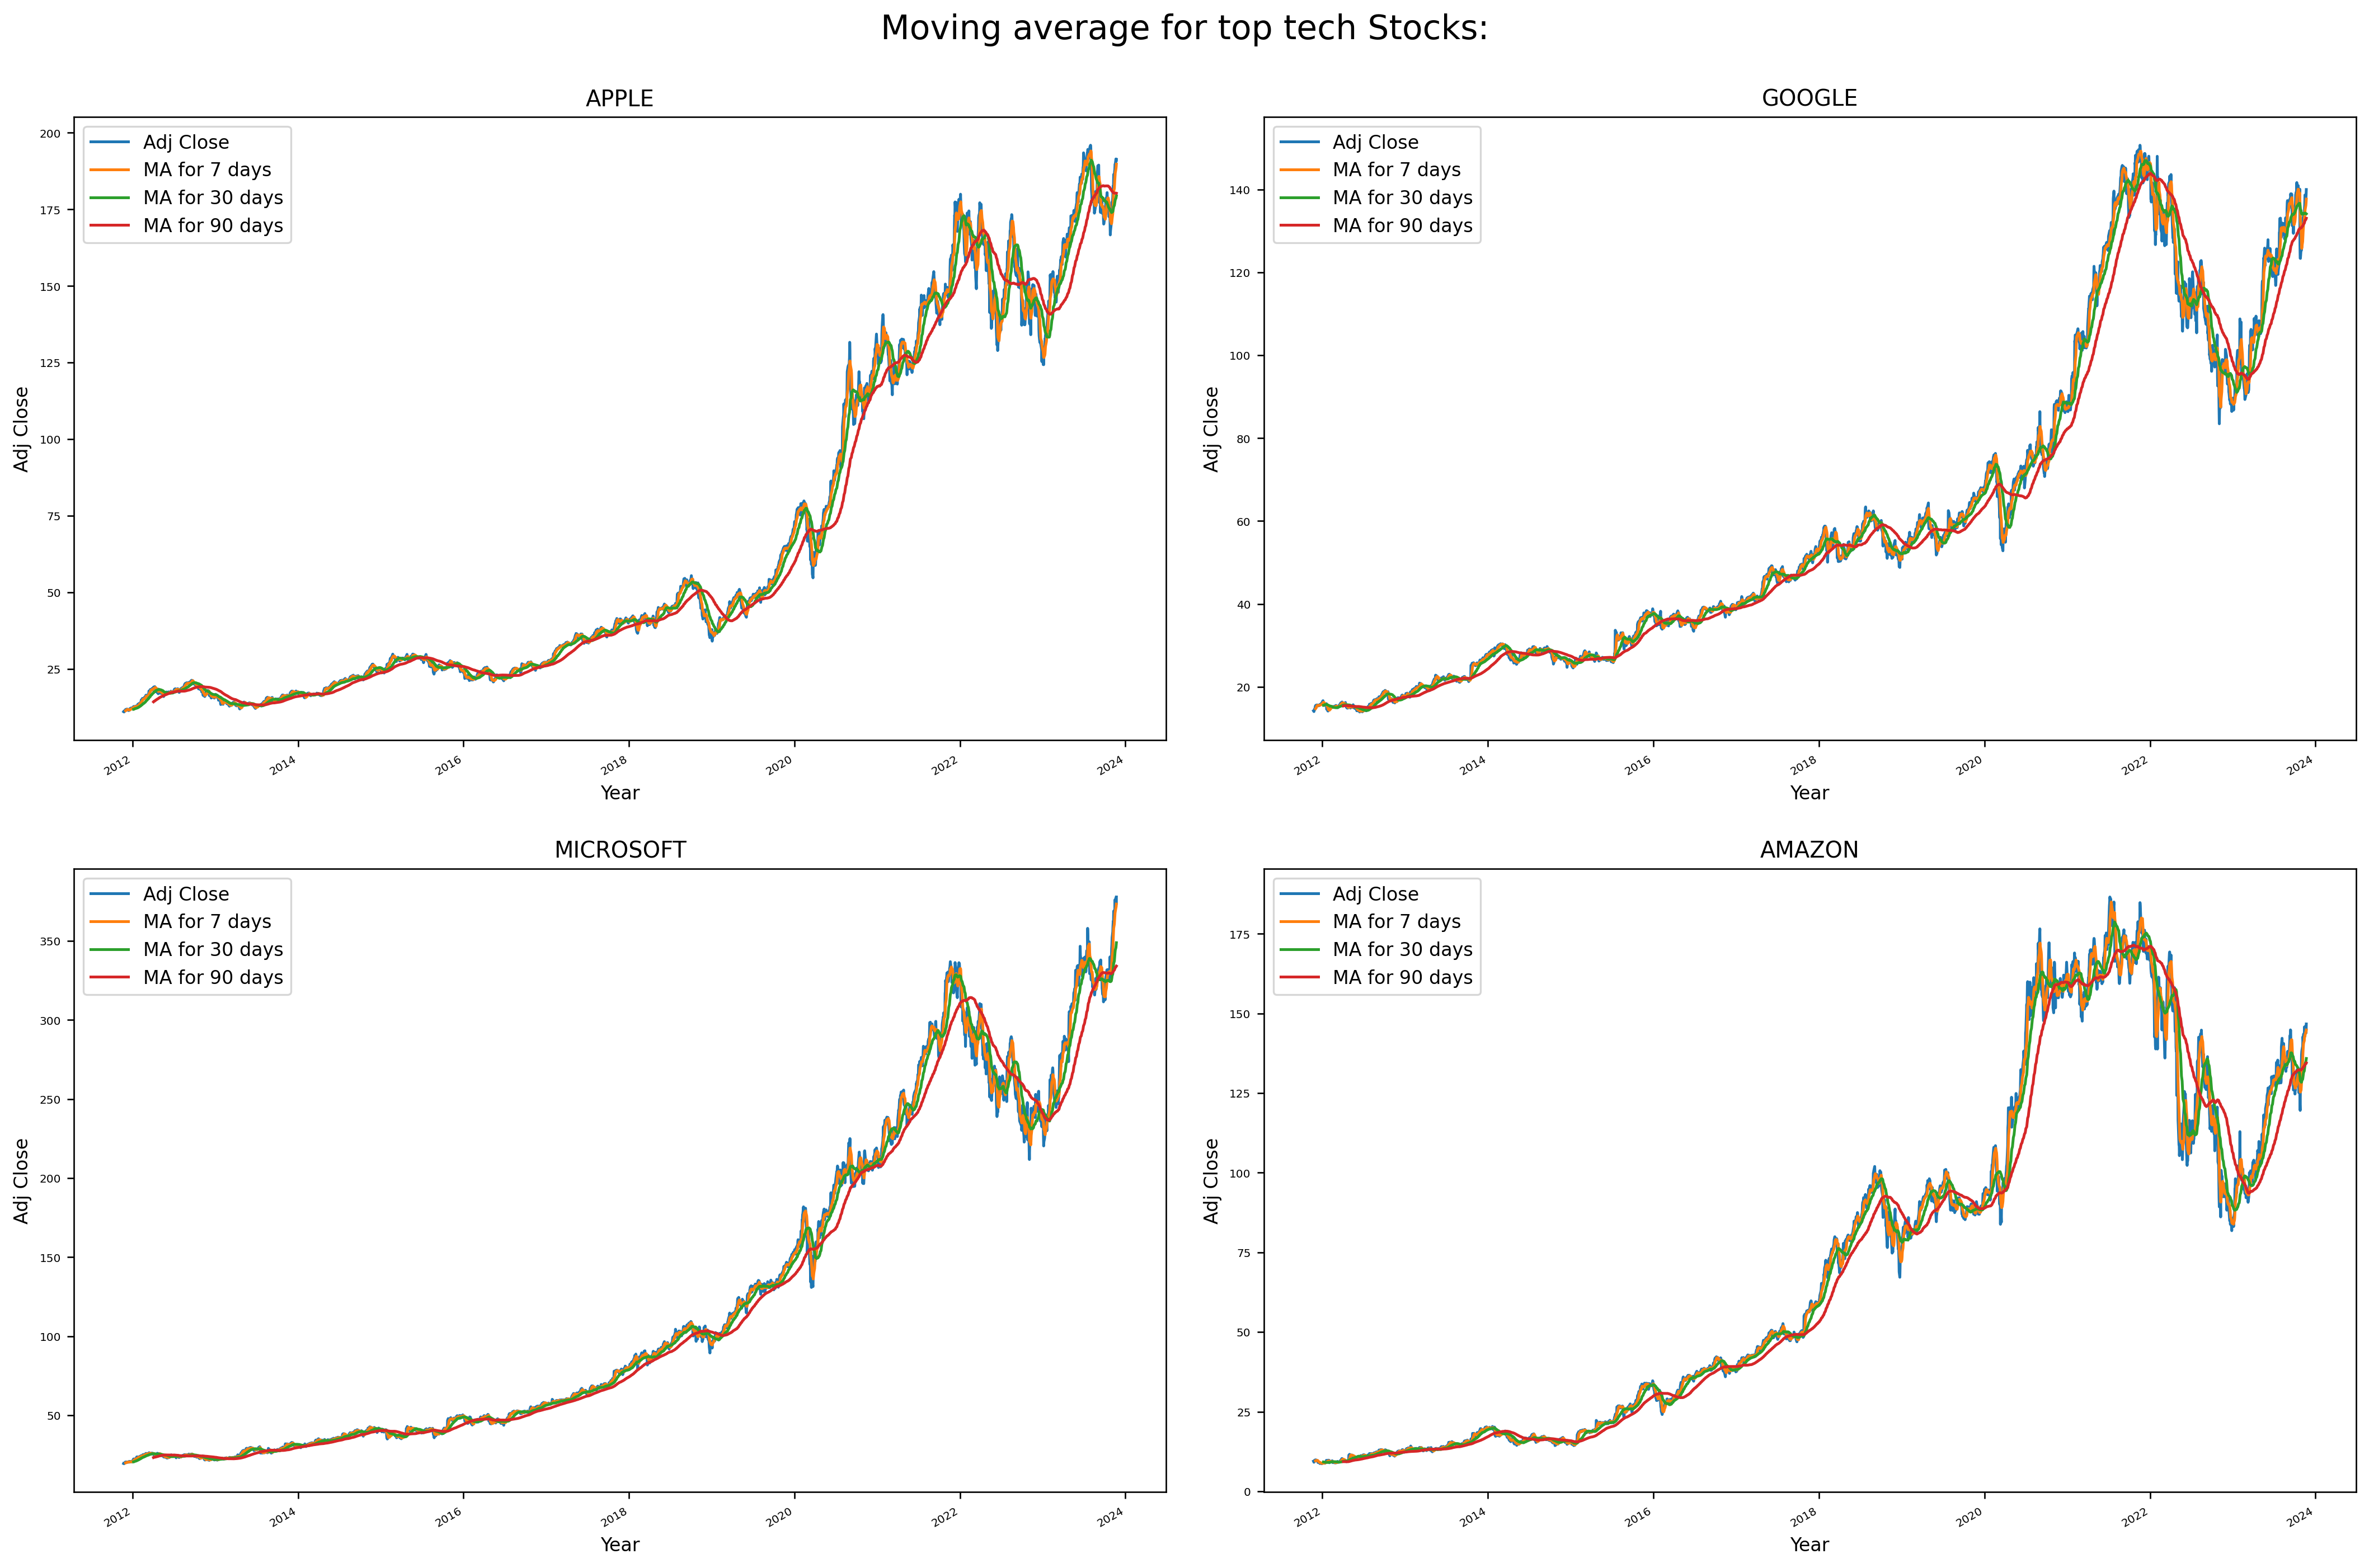

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plt.suptitle(f'Moving average for top tech Stocks:', fontsize=18)

# List of dataframes and titles
stocks_data = [
    {'data': AAPL, 'title': 'APPLE'},
    {'data': GOOG, 'title': 'GOOGLE'},
    {'data': MSFT, 'title': 'MICROSOFT'},
    {'data': AMZN, 'title': 'AMAZON'}
]

# Loop through the data and titles
for i, stock_info in enumerate(stocks_data):
    row = i // 2
    col = i % 2

    data = stock_info['data']
    title = stock_info['title']

    # Plot the data and set the title
    data[['Adj Close', 'MA for 7 days', 'MA for 30 days', 'MA for 90 days']].plot(ax=axes[row, col])
    axes[row, col].set_title(title)

    # Set x and y-axis labels
    axes[row, col].set_xlabel('Year', fontsize=10)
    axes[row, col].set_ylabel('Adj Close', fontsize=10)

# Adjust layout
plt.subplots_adjust(hspace=1, wspace=0.6)
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end, interval='1d')['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets = tech_rets.dropna()
# tech_rets.head(2)

[*********************100%%**********************]  4 of 4 completed


Pairplot for top tech Stocks:


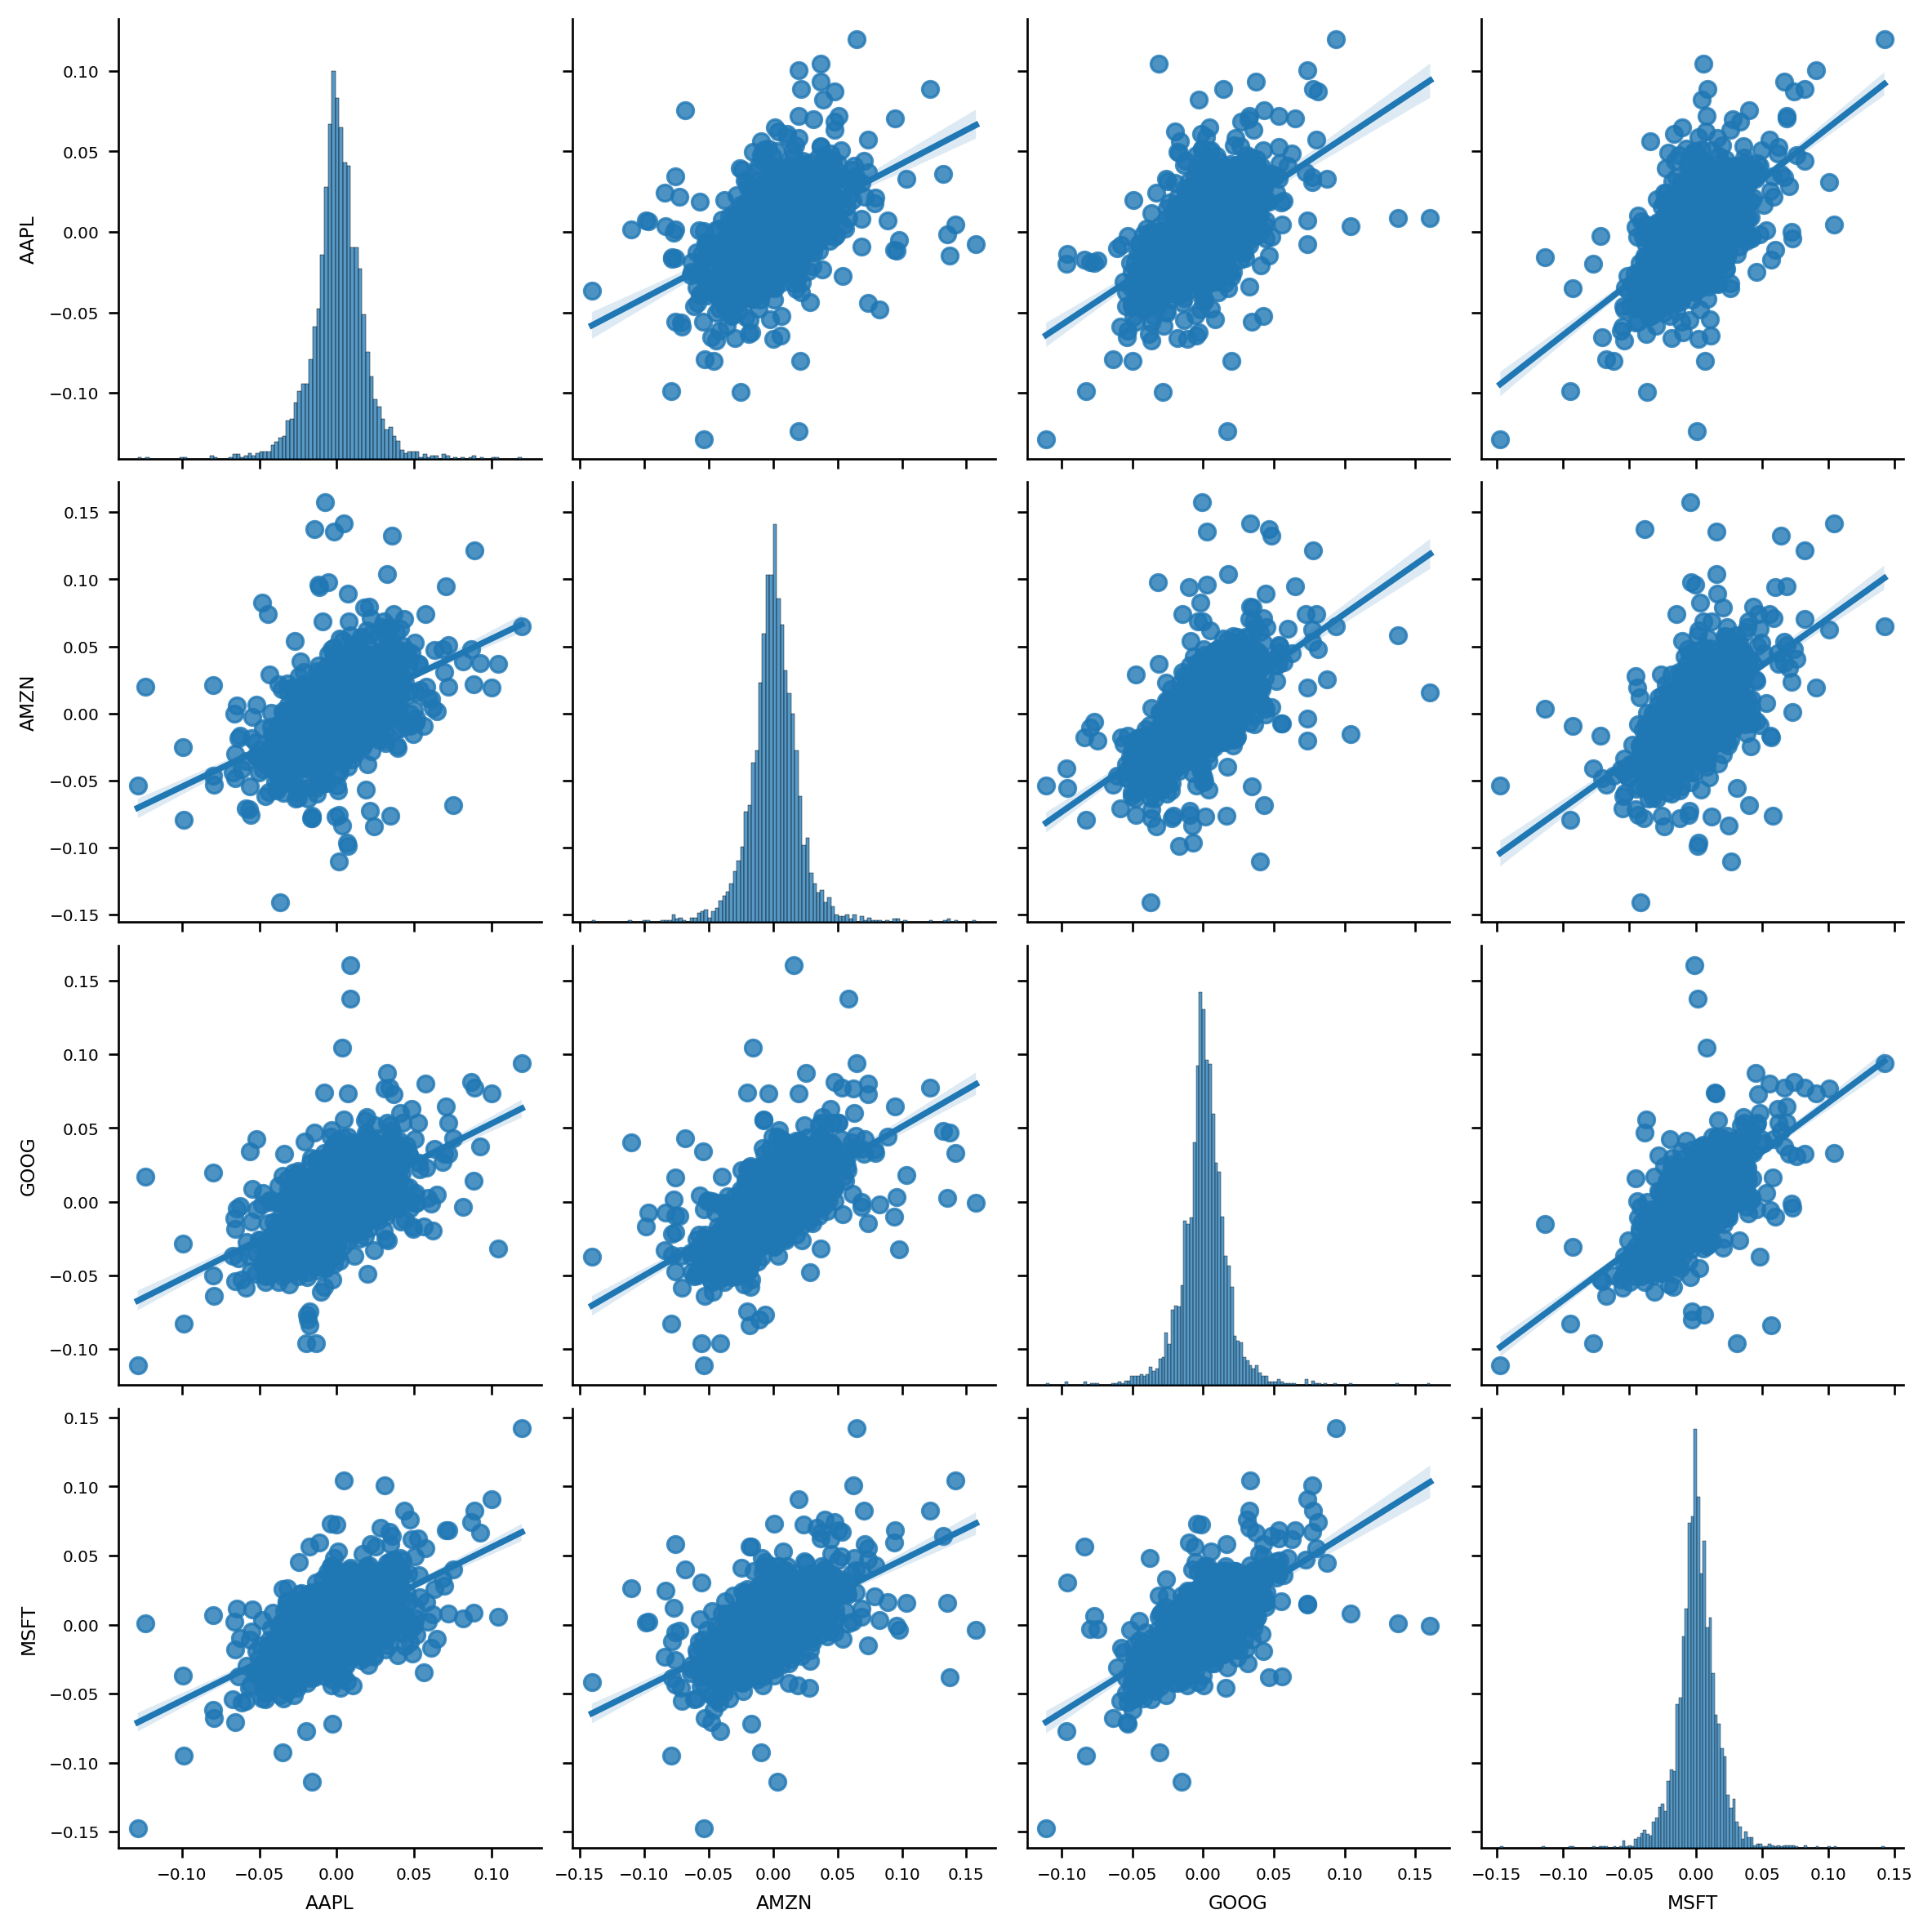

In [ ]:
print("Pairplot for top tech Stocks:")
# Create the pairplot with regression lines
sns.pairplot(tech_rets, kind='reg')

Text(0.5, 1.0, 'Correlation for top tech stock closing price')

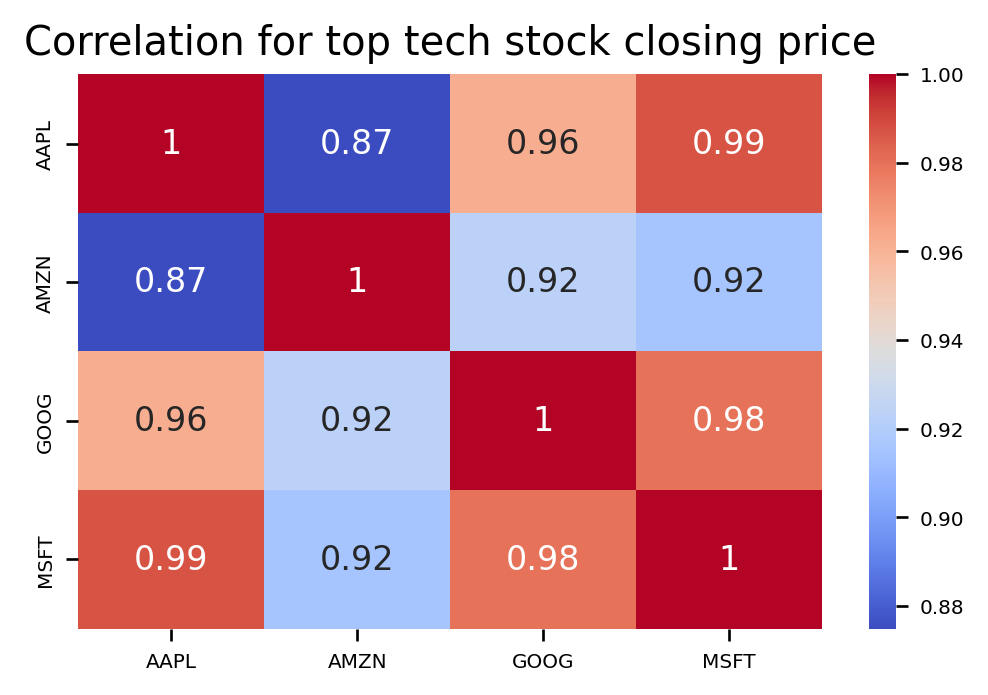

In [ ]:
plt.figure(figsize=(5, 3))

sns.heatmap(closing_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation for top tech stock closing price')

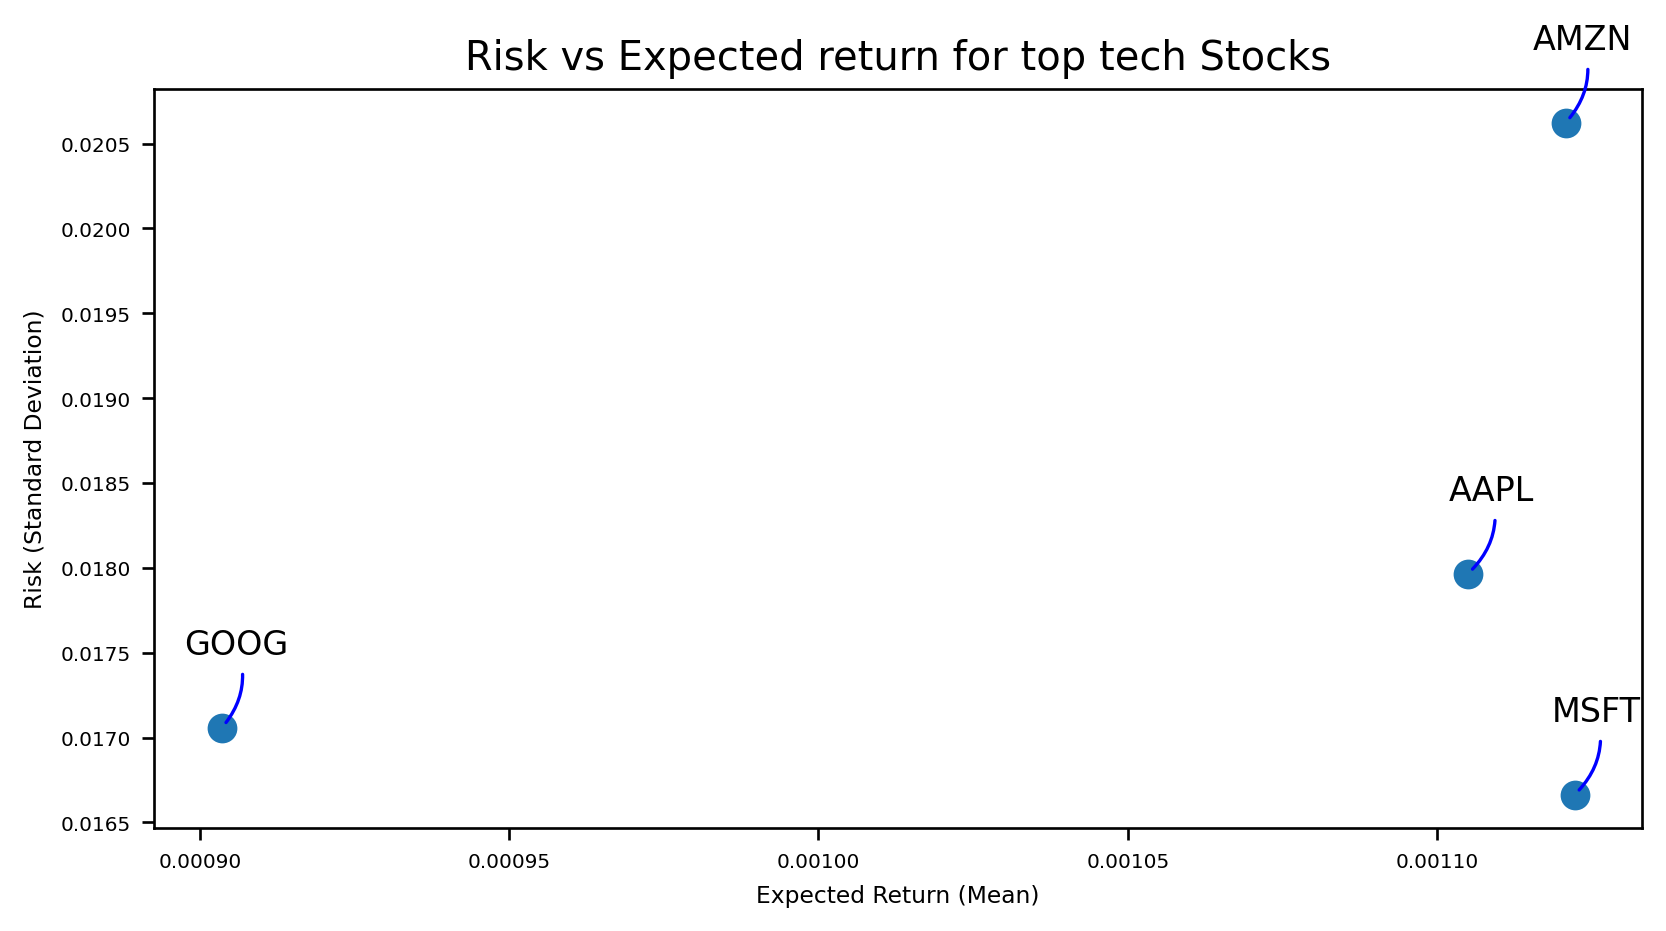

In [ ]:
rets = tech_rets.dropna()

# Calculate risk (standard deviation) and expected return (mean) for each stock
risk = rets.std()
expected_return = rets.mean()

# Create a DataFrame to store the results
stock_info_list = pd.DataFrame({'Stock Ticker': rets.columns, 'Risk': risk, 'Expected Return': expected_return})

# Create a scatter plot of risk vs. expected return
area = np.pi * 20
plt.figure(figsize=(8, 4))
plt.title('Risk vs Expected return for top tech Stocks')
plt.scatter(expected_return, risk, s=area)
plt.ylabel('Risk (Standard Deviation)')
plt.xlabel('Expected Return (Mean)')

# Annotate points with stock ticker names
for label, x, y in zip(stock_info_list['Stock Ticker'], expected_return, risk):
    plt.annotate(label, xy=(x, y), xytext=(20, 20), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

plt.show()

In [ ]:
# Sort the DataFrame in ascending order based on the 'Risk' column
sorted_stock_info = stock_info_list.sort_values(by='Risk', ascending=True)

display(sorted_stock_info)

Stock Ticker      Risk  Expected Return
MSFT         MSFT  0.016663         0.001122
GOOG         GOOG  0.017058         0.000904
AAPL         AAPL  0.017965         0.001105
AMZN         AMZN  0.020623         0.001121

In [ ]:
best_stock = sorted_stock_info['Stock Ticker'][0]
best_stock

'MSFT'

In [ ]:
# Get the best stock
best_stock_data = pdr.get_data_yahoo(best_stock, start, end, interval='1d')
best_stock_data.head(2)

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2011-11-23  24.610001  24.790001  24.469999  24.469999  19.449884  49099700
2011-11-25  24.379999  24.670000  24.299999  24.299999  19.314758  26164600

In [ ]:
best_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2011-11-23 to 2023-11-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3019 non-null   float64
 1   High       3019 non-null   float64
 2   Low        3019 non-null   float64
 3   Close      3019 non-null   float64
 4   Adj Close  3019 non-null   float64
 5   Volume     3019 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 165.1 KB


In [ ]:
# Get the number of rows to train the model on
train_len = int(np.ceil( len(best_stock_data) * .90 ))

train_len

2718

In [ ]:
steps_value = 90
data_target = best_stock_data.iloc[:train_len,4]
data_test = best_stock_data.iloc[train_len - steps_value:,4]

In [ ]:
# data_target.plot()

In [ ]:
# data_test.plot()

In [ ]:
data_pd = best_stock_data.filter(['Adj Close'])

In [ ]:
#return numpy representation of data
data = best_stock_data.loc[:,["Adj Close"]].values
test = data[train_len - steps_value:]

In [ ]:
true_value = data[train_len:]

In [ ]:
#Scaling Dataset
def scaledata(data_target):
    scaler = MinMaxScaler(feature_range=(0,1))
    #transform by converting it to array and shape of (-1,1)
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #returns scaled data
    return data_target_scaled, scaler

In [ ]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):
    x_patern = []
    y_price = []
    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        x_patern.append(row)
        y = data_target_scaled[day,0]
        y_price.append(y)

    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)
    return x_patern,y_price

In [ ]:
#Scale train data
data_target_scaled, scaler = scaledata(data_target)

#Scale test data
test = scaler.transform(test)

In [ ]:
len(data_target_scaled), len(test)

(2718, 391)

In [ ]:
#Overwrite steps to 90 for train set
train_pattern = createPatternSet(data_target_scaled,steps=steps_value)
x_train = train_pattern[0]
y_train = train_pattern[1]

print(x_train.shape, y_train.shape)

(2628, 90, 1) (2628,)


In [ ]:
#Overwrite steps to 90 for test set.
test_pattern = createPatternSet(test,steps=steps_value)
x_test = test_pattern[0]
y_test = test_pattern[1]

print(x_test.shape, y_test.shape)

(301, 90, 1) (301,)


In [ ]:
def plot_training_loss(history, title='Model'):
    plt.figure(figsize=(8, 4))
    plt.title(title, fontsize=18)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [ ]:
def get_predicted_prices(model, x_data, scaler):
    # Get the models predicted price values
    predictions = model.predict(x_data)

    # Inverse transform to original scale
    predictions = scaler.inverse_transform(predictions)

    return predictions

In [ ]:
def plot_valid_data_with_predictions(predicted_prices, title='Model'):
    valid = data_pd[train_len:]
    valid['Predictions'] = predicted_prices

    # Create a figure
    plt.figure(figsize=(8, 4))

    # Plot the validation data and predicted prices
    plt.plot(valid[['Adj Close', 'Predictions']])

    # Set labels and legend
    plt.title(title, fontsize=18)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.legend(['Real data (test)', 'Predictions'], loc='lower right')

    # Show the plot
    plt.show()

In [ ]:
def plot_all_data_with_predictions(predicted_prices, title='Model'):
    train = data_pd[:train_len]
    valid = data_pd[train_len:]
    valid['Predictions'] = predicted_prices

    # Create a figure
    plt.figure(figsize=(8, 4))

    # Plot the training data
    plt.plot(train['Adj Close'], label='Train')

    # Plot the validation data and predicted prices
    plt.plot(valid[['Adj Close', 'Predictions']])

    # Set labels and legend
    plt.title(title, fontsize=18)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.legend(['Real data (Train)', 'Real data (Val)', 'Predictions'], loc='lower right')

    # Show the plot
    plt.show()

In [ ]:
# Define the RNN model baseline
model_rnn = Sequential()

# Add a Simple RNN layer with 512 units and input shape (time_steps, features)
model_rnn.add(SimpleRNN(512, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add a Simple RNN layer with 256 units
model_rnn.add(SimpleRNN(256, return_sequences=True))

# Add a Simple RNN layer with 256 units
model_rnn.add(SimpleRNN(256, return_sequences=False))

# Add a Dense layer with 128 units and ReLU activation
model_rnn.add(Dense(128, activation='relu'))

# Add the Dropout
model_rnn.add(Dropout(0.3))

# Add the output layer with 1 unit (for regression tasks)
model_rnn.add(Dense(1))

In [ ]:
# Print the model summary
model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 90, 512)           263168    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 90, 256)           196864    
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 624385 (2.38 MB)
Trainable params: 62438

In [ ]:
# Compile the model
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_rnn = model_rnn.fit(x_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
83/83 [==============================] - 22s 219ms/step - loss: 0.3427
Epoch 2/200
83/83 [==============================] - 18s 216ms/step - loss: 0.0901
Epoch 3/200
83/83 [==============================] - 20s 241ms/step - loss: 0.0818
Epoch 4/200
83/83 [==============================] - 18s 217ms/step - loss: 0.0817
Epoch 5/200
83/83 [==============================] - 19s 233ms/step - loss: 0.0815
Epoch 6/200
83/83 [==============================] - 19s 230ms/step - loss: 0.0804
Epoch 7/200
83/83 [==============================] - 18s 219ms/step - loss: 0.0800
Epoch 8/200
83/83 [==============================] - 20s 240ms/step - loss: 0.0782
Epoch 9/200
83/83 [==============================] - 18s 219ms/step - loss: 0.0802
Epoch 10/200
83/83 [==============================] - 19s 228ms/step - loss: 0.0782
Epoch 11/200
83/83 [==============================] - 20s 242ms/step - loss: 0.0588
Epoch 12/200
83/83 [==============================] - 19s 228ms/step - loss: 0.0874
E

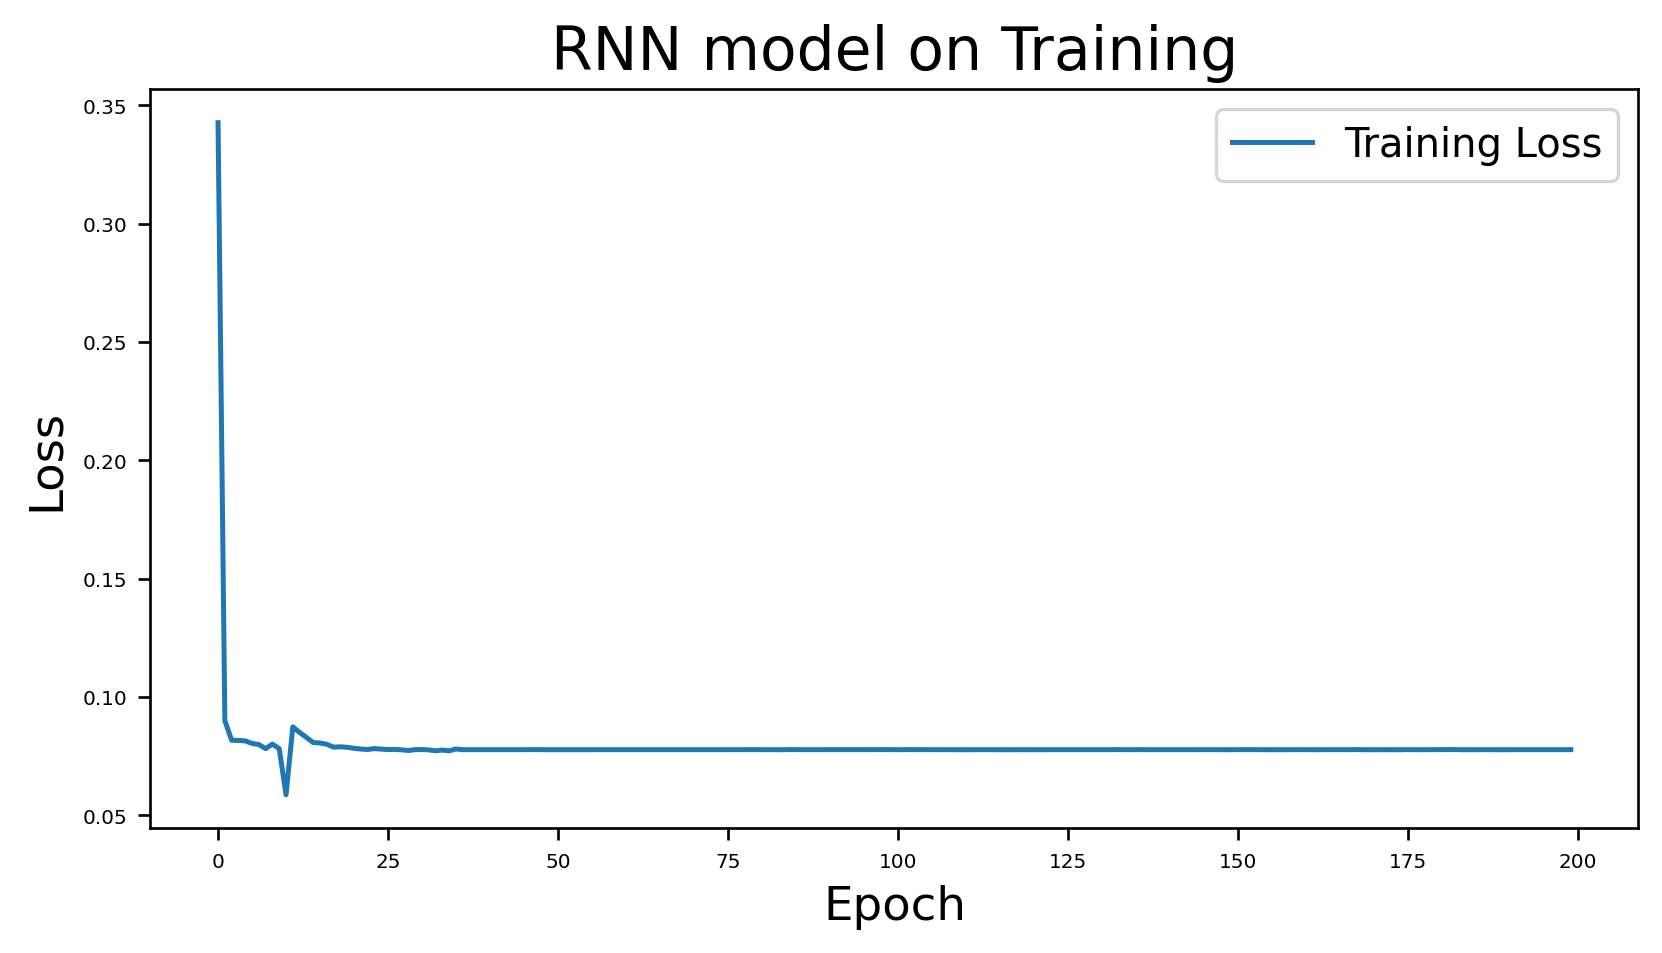

In [ ]:
plot_training_loss(history_rnn, "RNN model on Training")

In [4]:
# Get the models predicted price values
predicted_prices_rnn_t = get_predicted_prices(model_rnn, x_test, scaler)

# Get the root mean squared error (RMSE)
rmse_rnn = np.sqrt(np.mean(((predicted_prices_rnn_t - true_value) ** 2)))
print("Root mean squared error (RMSE) for the RNN model:", rmse_rnn)

10/10 [==============================] - 0s 20ms/step
Root mean squared error (RMSE) for the RNN model: 198.02792000962393


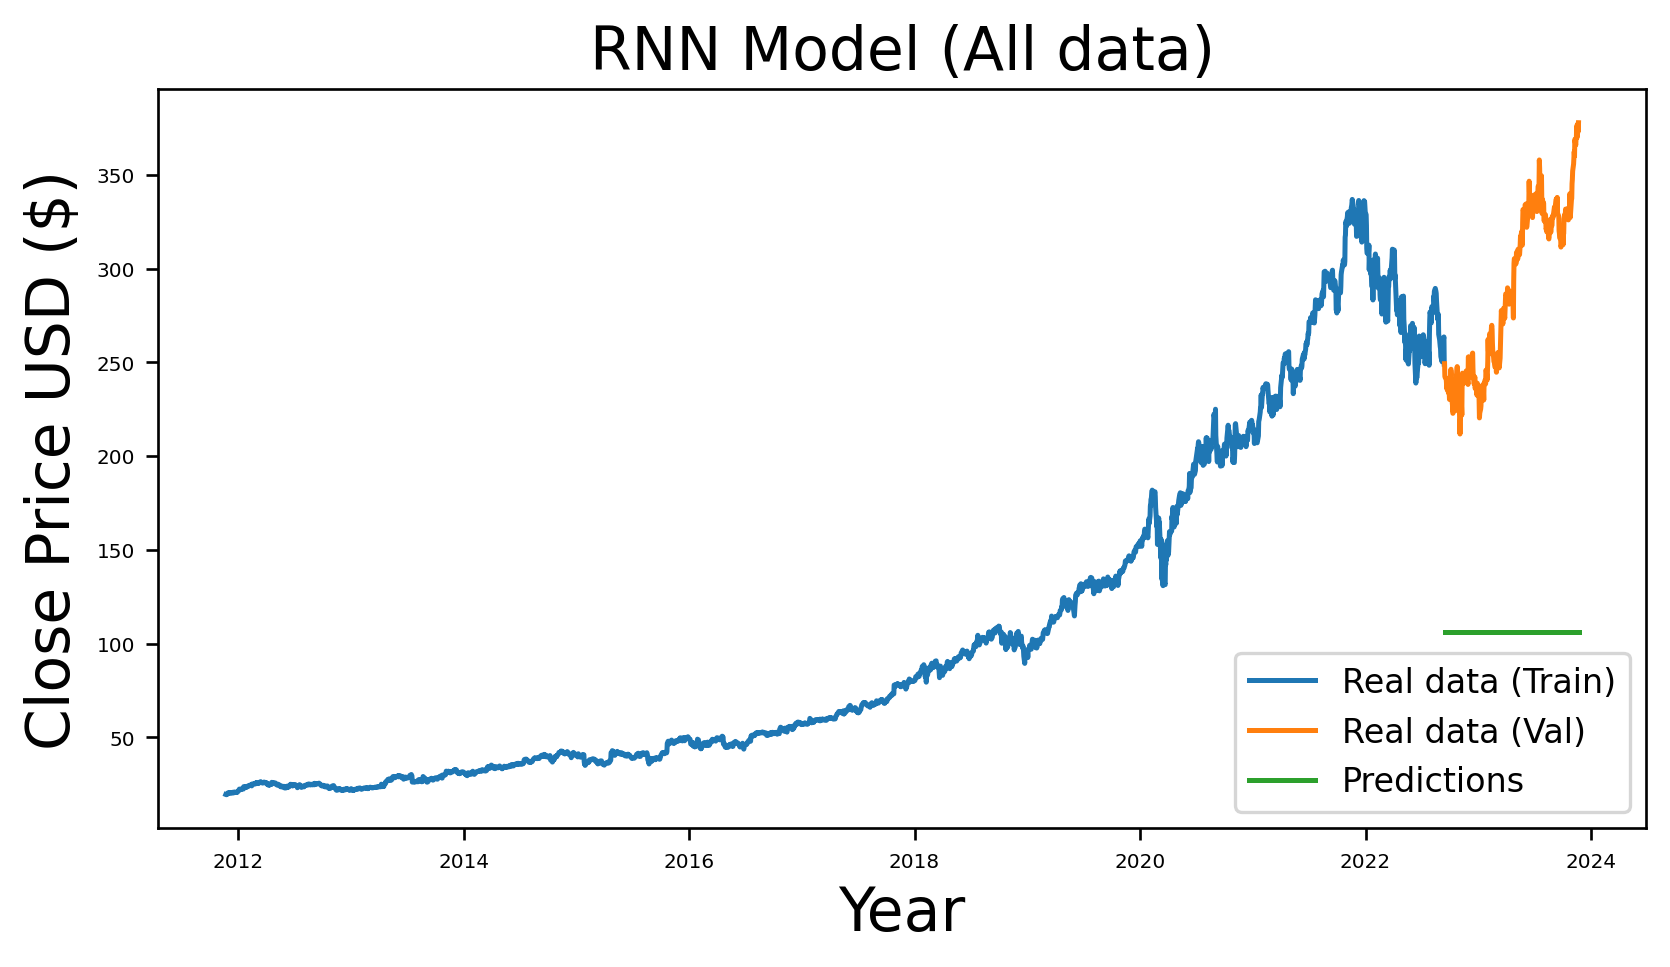

In [ ]:
plot_all_data_with_predictions(predicted_prices_rnn_t, title='RNN Model (All data)')

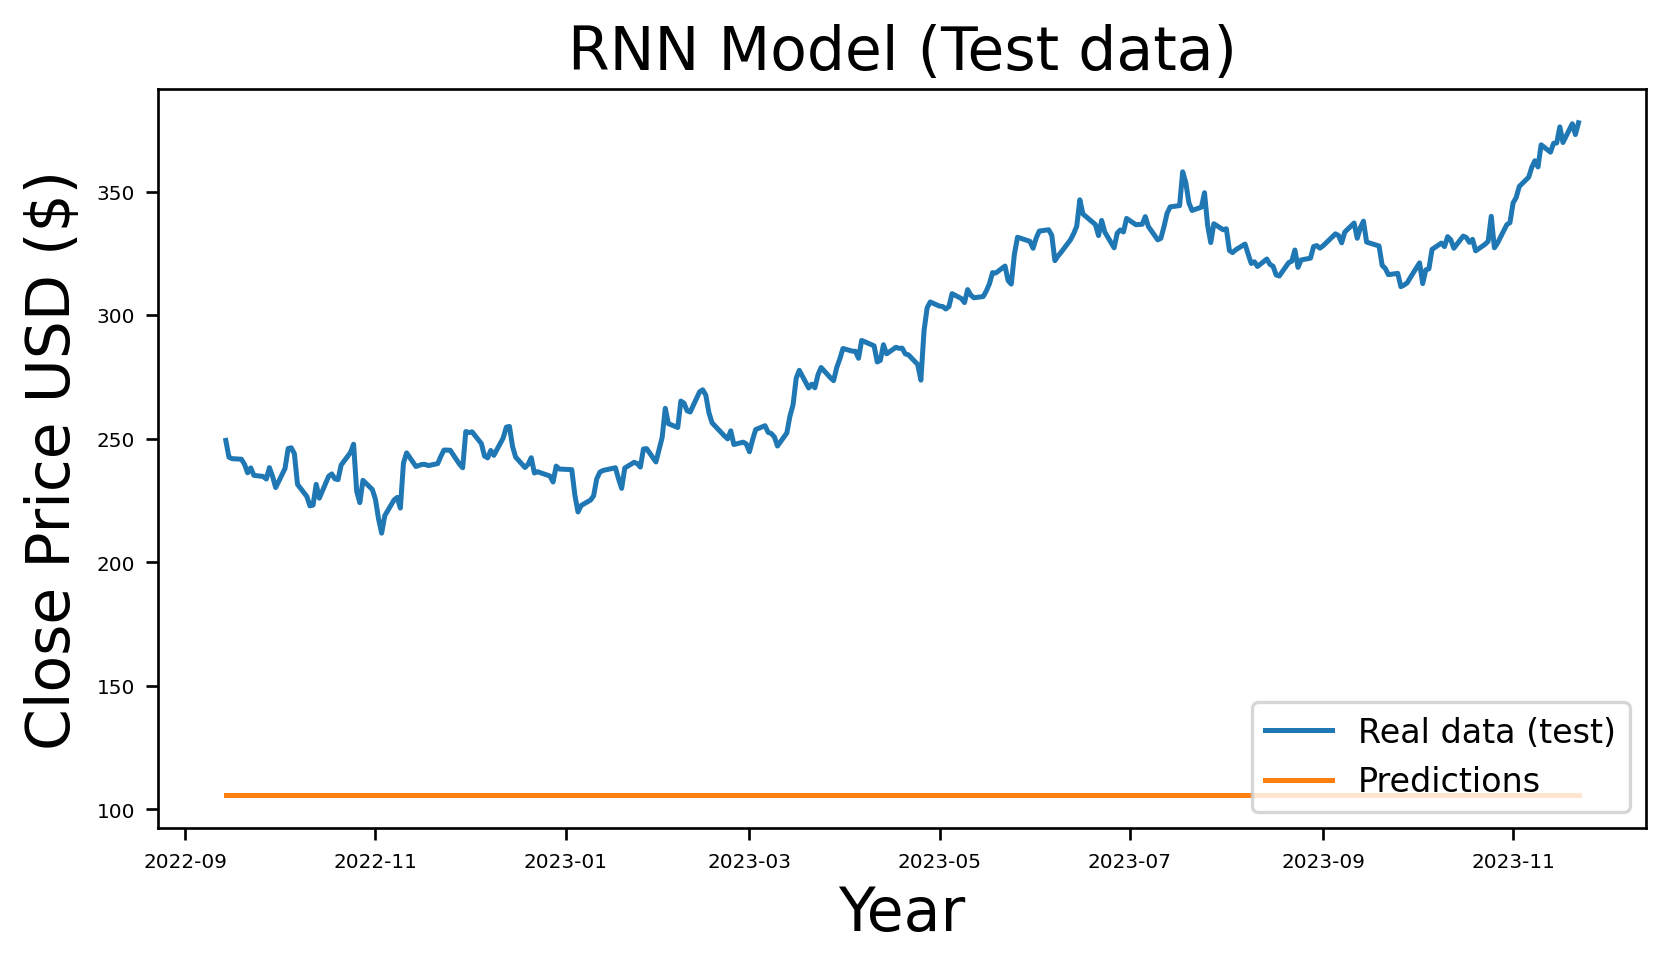

In [ ]:
plot_valid_data_with_predictions(predicted_prices_rnn_t, title='RNN Model (Test data)')

In [ ]:
# Get the total number of parameters in the model
total_params_rnn = model_rnn.count_params()

print("Total parameters in the RNN model:", total_params_rnn)

Total parameters in the RNN model: 624385


In [ ]:
# Build the LSTM model

# Define the RNN model
model_lstm = Sequential()

# Add a Simple LSTM layer with 512 units and input shape (time_steps, features)
model_lstm.add(LSTM(512, return_sequences=True, input_shape= (x_train.shape[1], 1)))

# Add a Simple RNN layer with 256 units
model_lstm.add(LSTM(256, return_sequences=True))

# Add a Simple RNN layer with 256 units
model_lstm.add(LSTM(256, return_sequences=False))

# Add a Dense layer with 128 units and ReLU activation
model_lstm.add(Dense(128, activation='relu'))

# Add the Dropout
model_lstm.add(Dropout(0.3))

# Add the output layer with 1 unit (for regression tasks)
model_lstm.add(Dense(1))

In [ ]:
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 90, 512)           1052672   
                                                                 
 lstm_7 (LSTM)               (None, 90, 256)           787456    
                                                                 
 lstm_8 (LSTM)               (None, 256)               525312    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2398465 (9.15 MB)
Trainable params: 2398

In [ ]:
# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_lstm = model_lstm.fit(x_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
83/83 [==============================] - 38s 27ms/step - loss: 0.0139
Epoch 2/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0026
Epoch 3/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0028
Epoch 4/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0024
Epoch 5/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0020
Epoch 6/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0020
Epoch 7/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0018
Epoch 8/200
83/83 [==============================] - 2s 27ms/step - loss: 0.0019
Epoch 9/200
83/83 [==============================] - 2s 27ms/step - loss: 0.0019
Epoch 10/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0015
Epoch 11/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0014
Epoch 12/200
83/83 [==============================] - 2s 26ms/step - loss: 0.0014
Epoch 13/200
83/83 [====

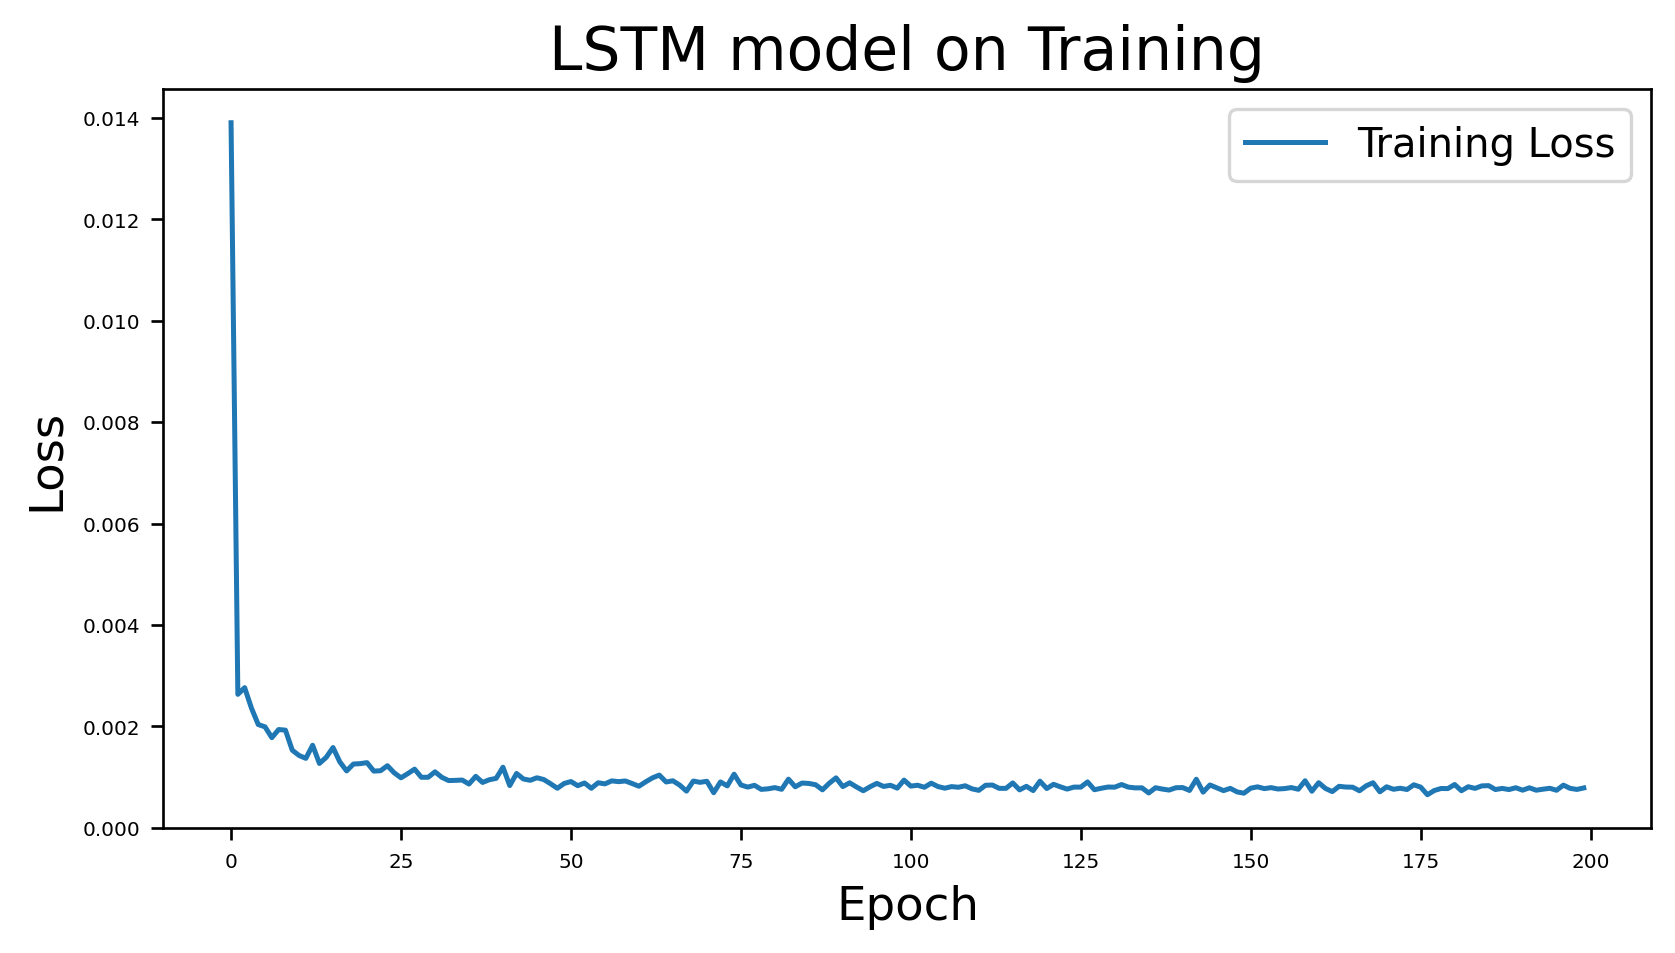

In [ ]:
plot_training_loss(history_lstm, "LSTM model on Training")

In [7]:
# Get the models predicted price values
predicted_prices_lstm_t = get_predicted_prices(model_lstm, x_test, scaler)

# Get the root mean squared error (RMSE)
rmse_lstm = np.sqrt(np.mean(((predicted_prices_lstm_t - true_value) ** 2)))
print("Root mean squared error (RMSE) for the LSTM model:", rmse_lstm)

10/10 [==============================] - 1s 10ms/step
Root mean squared error (RMSE) for the LSTM model: 6.35525117847427


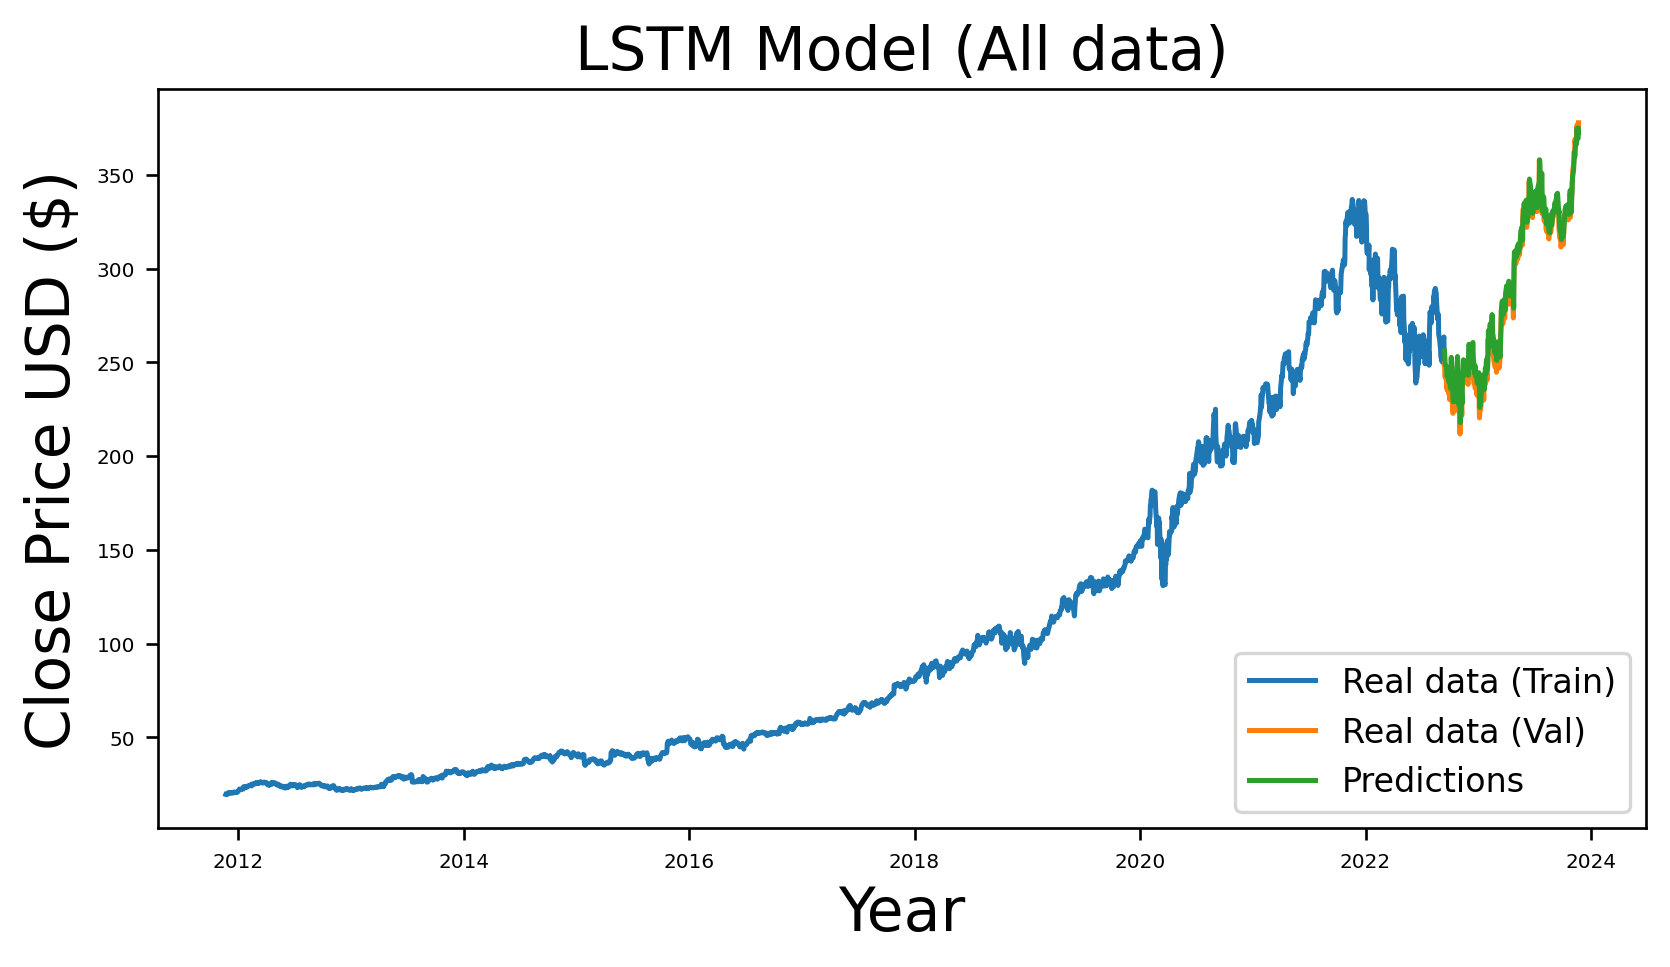

In [ ]:
plot_all_data_with_predictions(predicted_prices_lstm_t, title='LSTM Model (All data)')

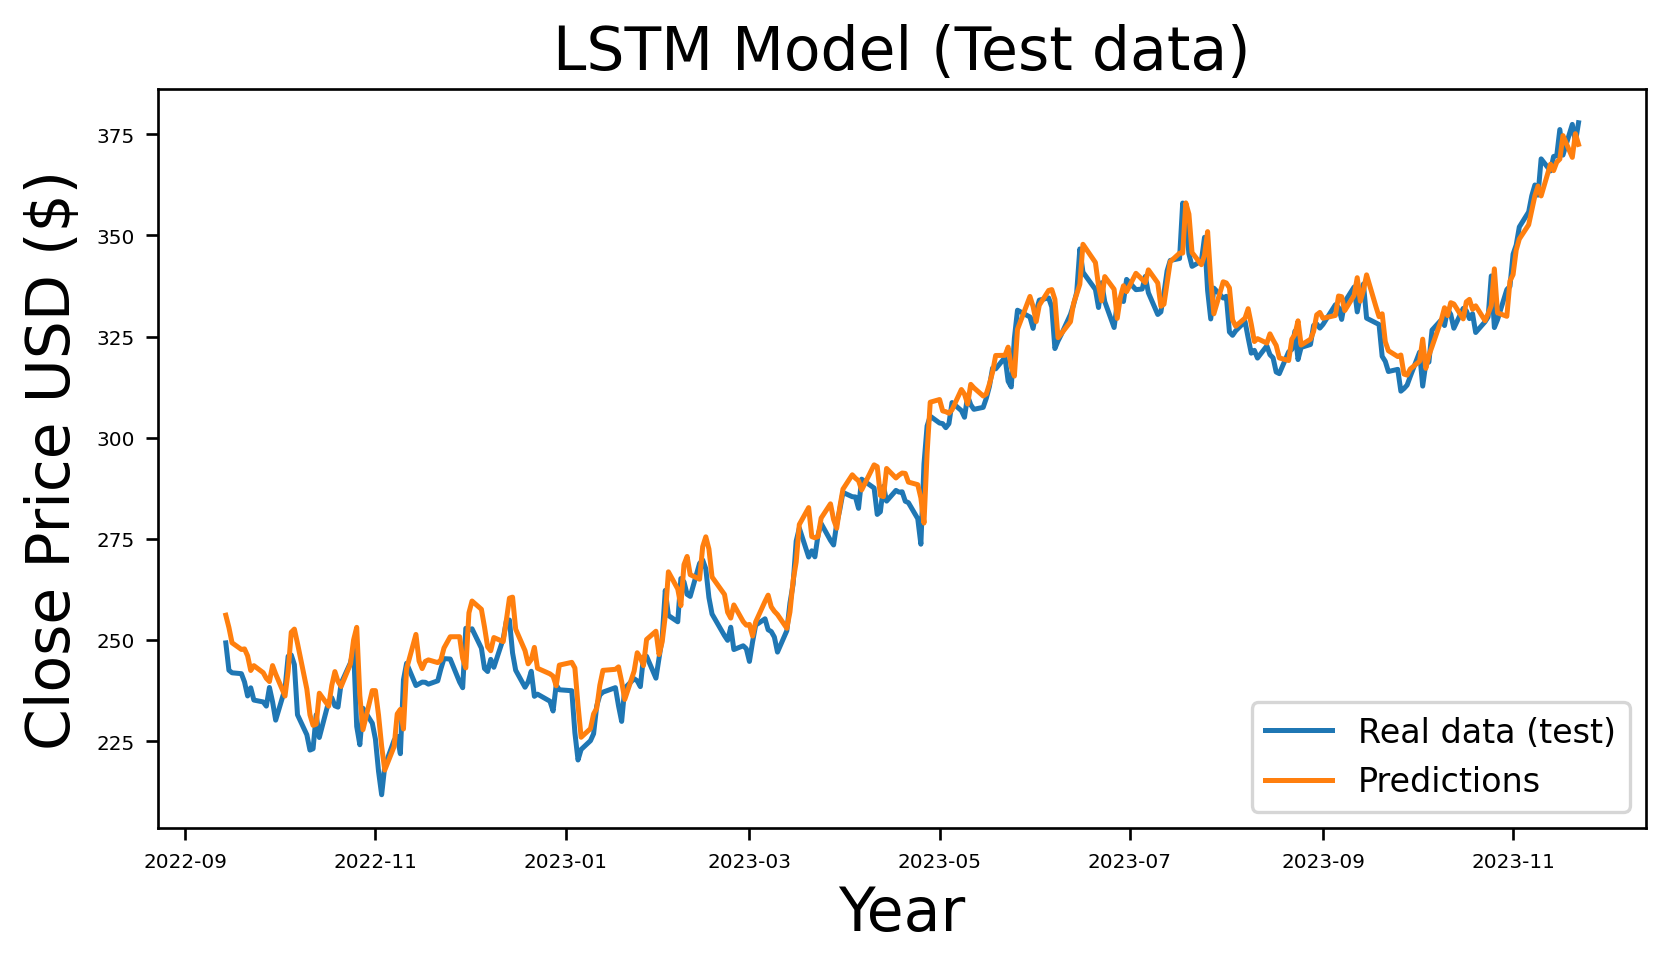

In [ ]:
plot_valid_data_with_predictions(predicted_prices_lstm_t, title='LSTM Model (Test data)')

In [ ]:
# Get the total number of parameters in the model
total_params_lstm = model_lstm.count_params()

print("Total parameters in the LSTM model:", total_params_lstm)

Total parameters in the LSTM model: 2398465


In [ ]:
# Define the GRU model
model_gru = Sequential()

# Add a GRU layer with 512 units and input shape (time_steps, features)
model_gru.add(GRU(512, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add a Dense layer with 256 units and ReLU activation
model_gru.add(GRU(256, return_sequences=True, activation='relu'))

# Add a Dense layer with 256 units and ReLU activation
model_gru.add(GRU(256, return_sequences=False, activation='relu'))

# Add the Dense layer with 128 unit
model_gru.add(Dense(128))

# Add the Dropout
model_gru.add(Dropout(0.3))

# Add the output layer with 1 unit (for regression tasks)
model_gru.add(Dense(1))

In [ ]:
# Print the model summary
model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 90, 512)           791040    
                                                                 
 gru_5 (GRU)                 (None, 90, 256)           591360    
                                                                 
 gru_6 (GRU)                 (None, 256)               394752    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1810177 (6.91 MB)
Trainable params: 1810

In [ ]:
# Compile the model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_gru = model_gru.fit(x_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
83/83 [==============================] - 39s 392ms/step - loss: 0.0059
Epoch 2/200
83/83 [==============================] - 33s 399ms/step - loss: 0.0014
Epoch 3/200
83/83 [==============================] - 34s 401ms/step - loss: 0.0010
Epoch 4/200
83/83 [==============================] - 32s 384ms/step - loss: 8.4036e-04
Epoch 5/200
83/83 [==============================] - 34s 411ms/step - loss: 0.0010
Epoch 6/200
83/83 [==============================] - 32s 387ms/step - loss: 0.0015
Epoch 7/200
83/83 [==============================] - 32s 387ms/step - loss: 8.2272e-04
Epoch 8/200
83/83 [==============================] - 34s 410ms/step - loss: 8.0799e-04
Epoch 9/200
83/83 [==============================] - 41s 490ms/step - loss: 8.7410e-04
Epoch 10/200
83/83 [==============================] - 39s 466ms/step - loss: 7.5818e-04
Epoch 11/200
83/83 [==============================] - 56s 679ms/step - loss: 7.5830e-04
Epoch 12/200
83/83 [==============================] - 43s 515

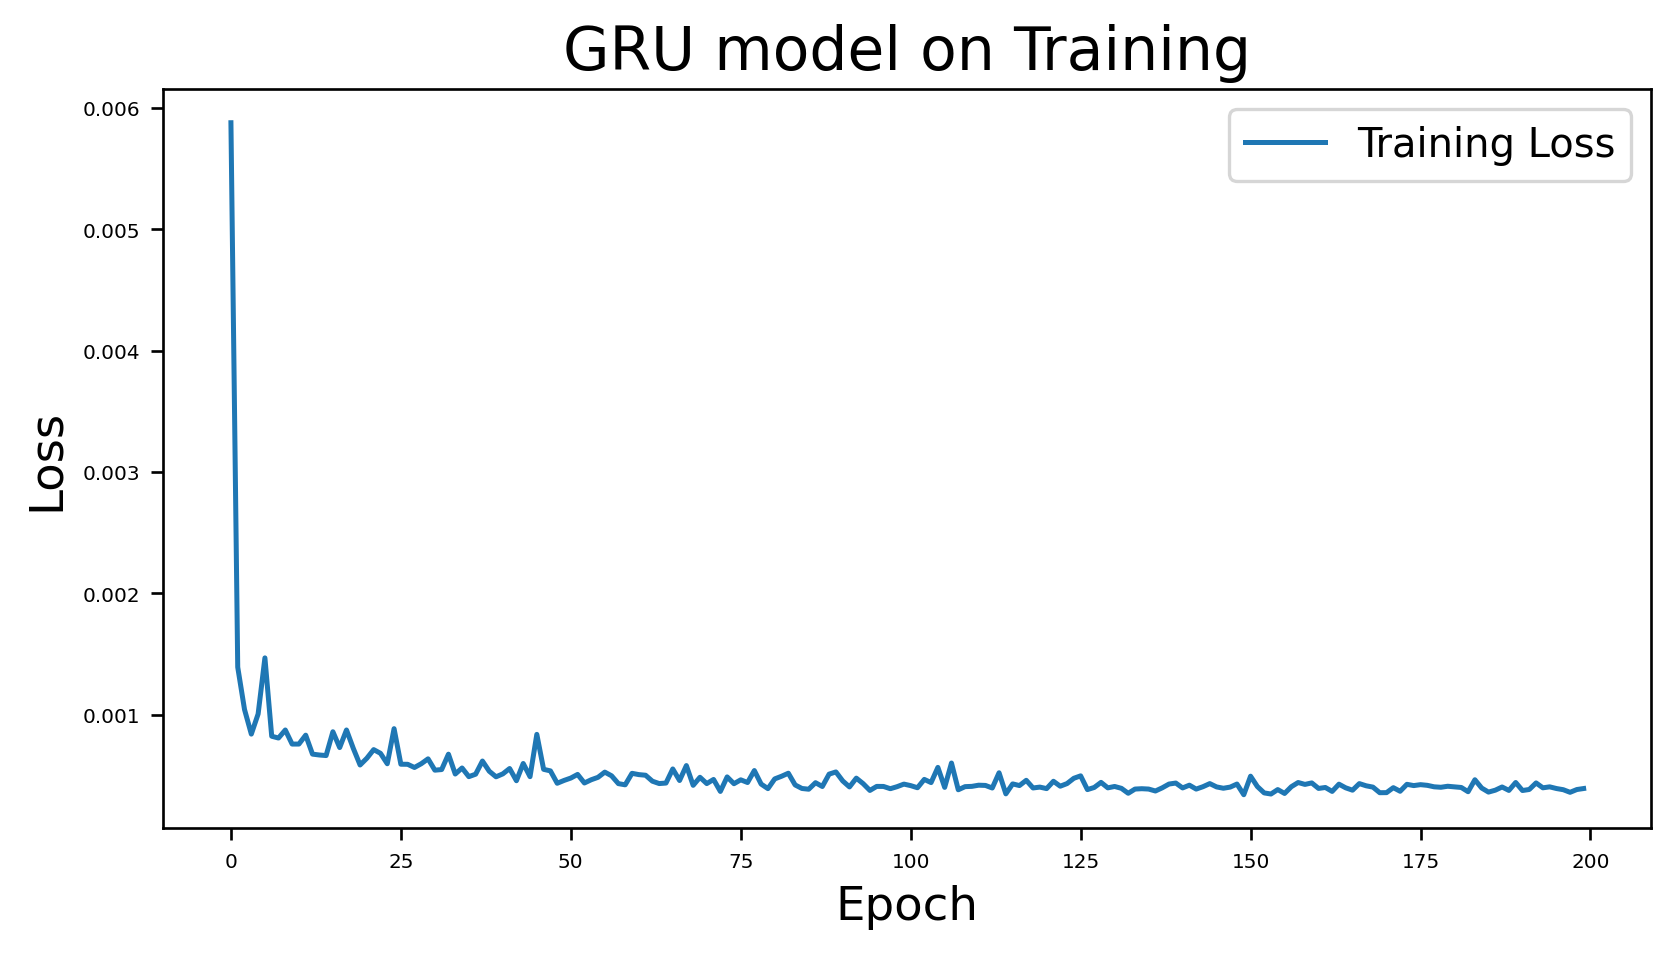

In [ ]:
plot_training_loss(history_gru, "GRU model on Training")

In [10]:
# Get the models predicted price values
predicted_prices_gru_t = get_predicted_prices(model_gru, x_test, scaler)

# Get the root mean squared error (RMSE)
rmse_gru = np.sqrt(np.mean(((predicted_prices_gru_t - true_value) ** 2)))
print("Root mean squared error (RMSE) for the GRU model:", rmse_gru)

10/10 [==============================] - 1s 35ms/step
Root mean squared error (RMSE) for the GRU model: 8.609659913160124


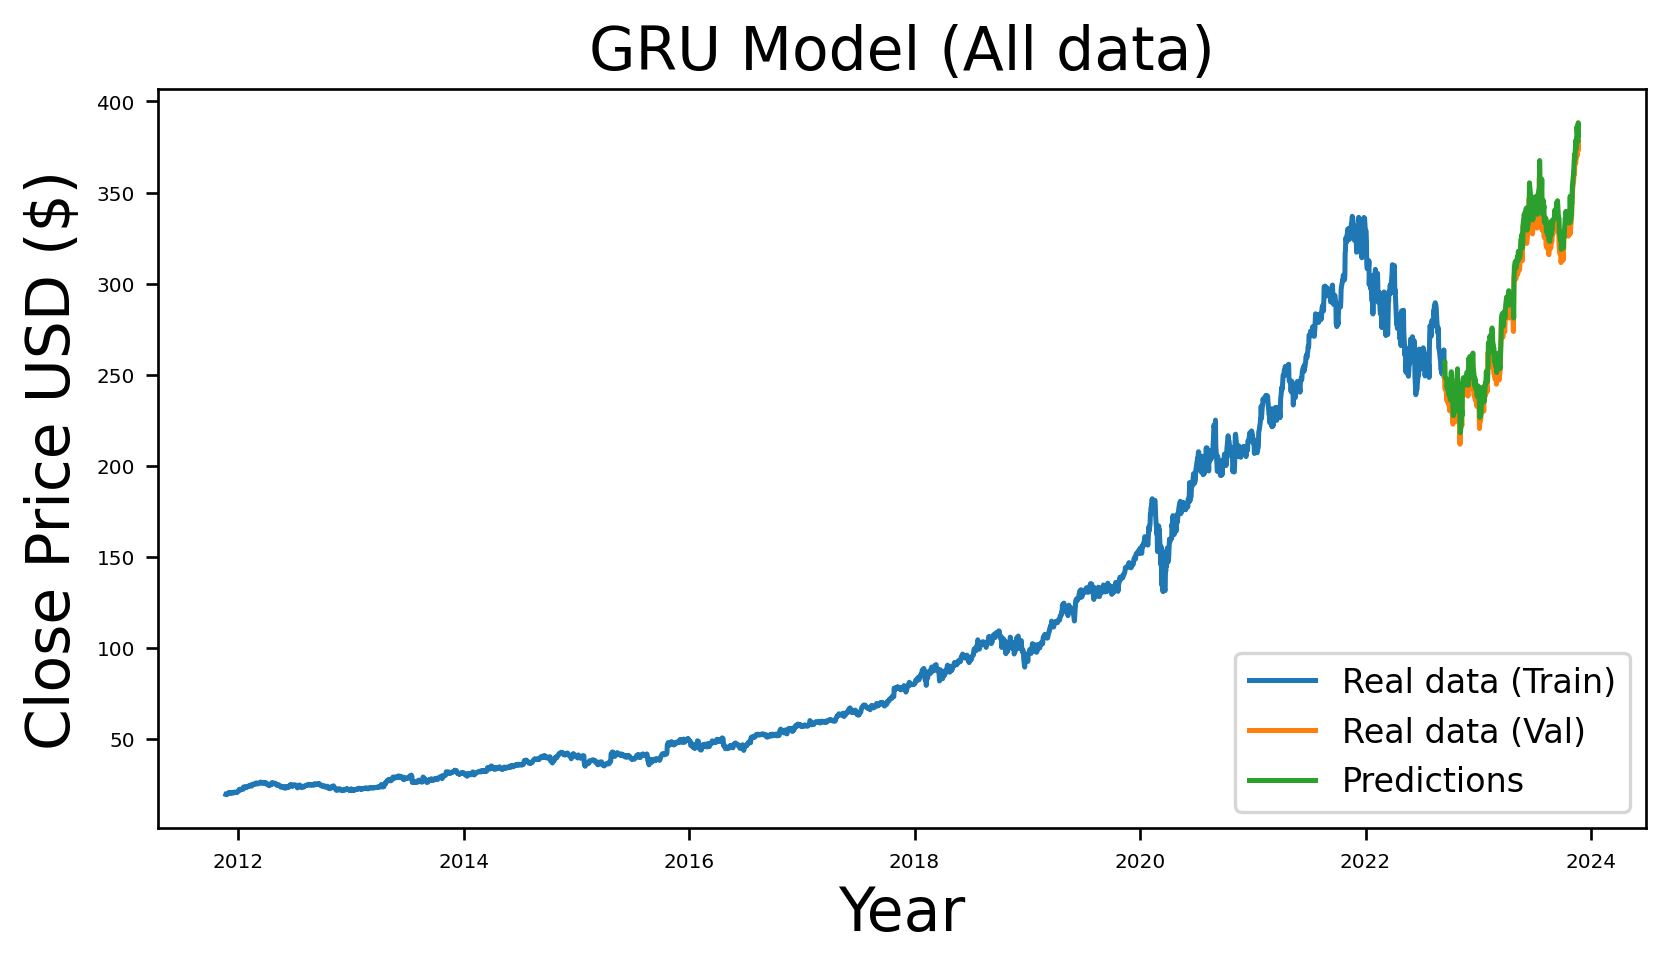

In [ ]:
plot_all_data_with_predictions(predicted_prices_gru_t, title='GRU Model (All data)')

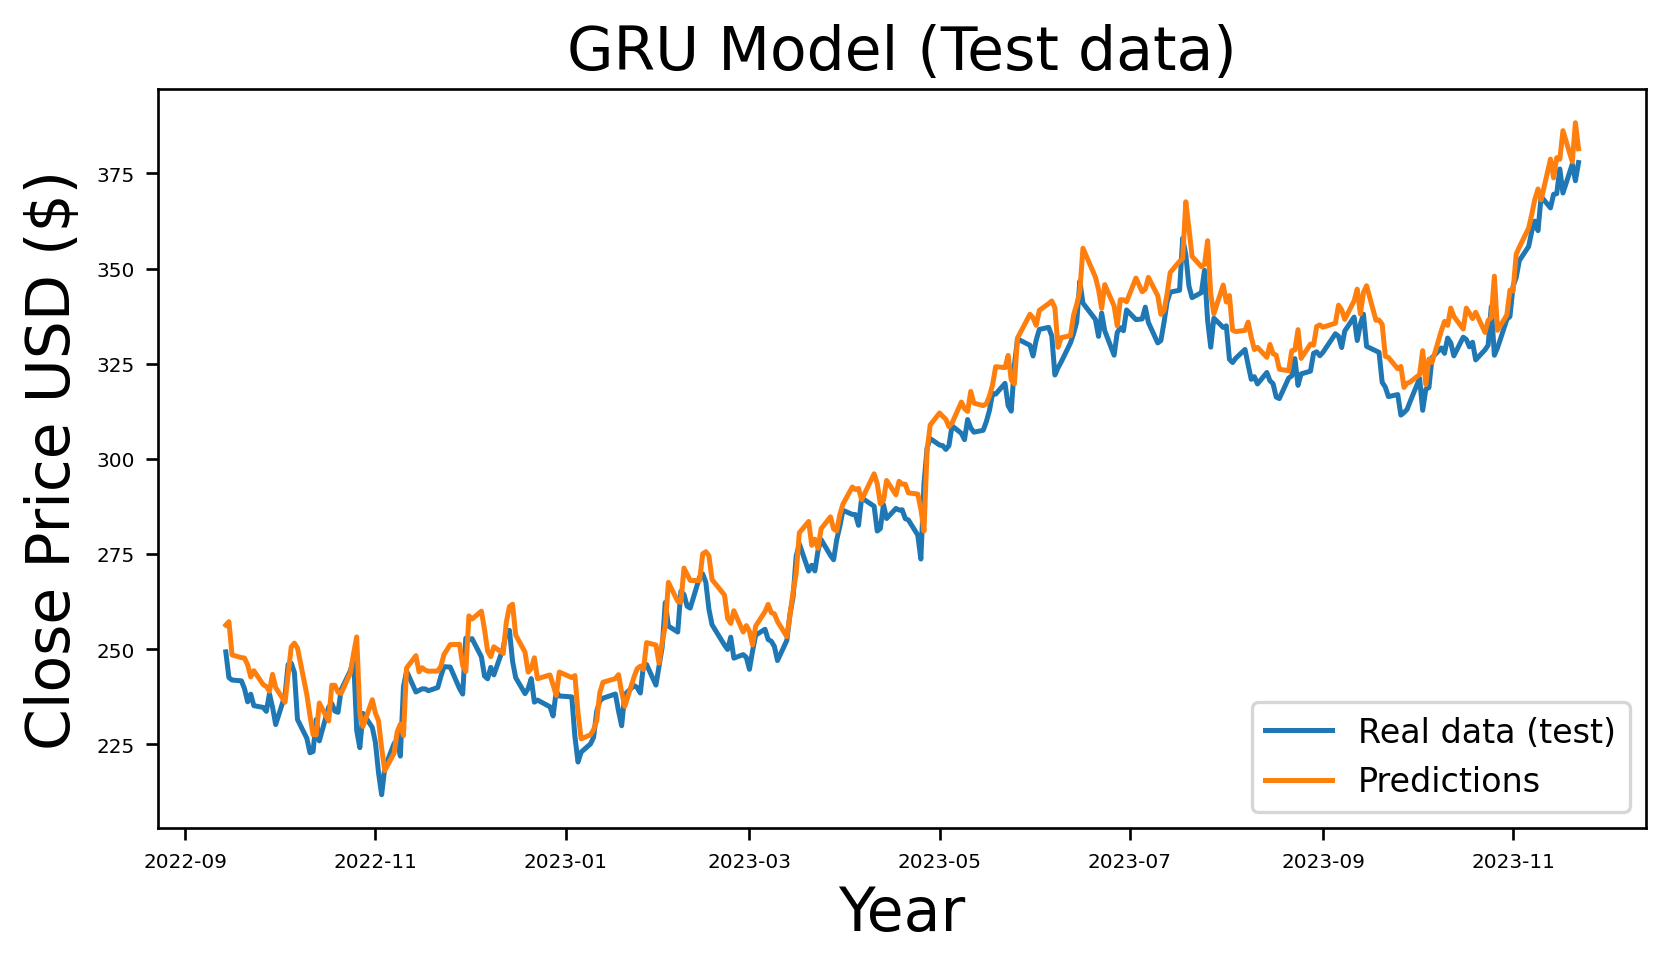

In [ ]:
plot_valid_data_with_predictions(predicted_prices_gru_t, title='GRU Model (Test data)')

In [ ]:
# Get the total number of parameters in the model
total_params_gru = model_gru.count_params()

print("Total parameters in the GRU model:", total_params_gru)

Total parameters in the GRU model: 1810177


In [12]:
# Sample metrics_df_new
metrics_df_comp_r = pd.DataFrame(
                   {
                    'Model': [
                              'RNN (Baseline)',
                              'LSTM',
                              'GRU'
                             ],

                    'RMSE (AVG)': [
                                   round(float(rmse_rnn), 3),
                                   round(float(rmse_lstm), 3),
                                   round(float(rmse_gru), 3)
                                   ],

                    'Total Parameters': [
                                         round(float(total_params_rnn), 3),
                                         round(float(total_params_lstm), 3),
                                         round(float(total_params_gru), 3)
                                        ]
                   })

In [13]:
metrics_df_comp = metrics_df_comp_r.copy()
metrics_df_comp_r

Model  RMSE (AVG)  Total Parameters
0  RNN (Baseline)     198.028          624385.0
1            LSTM       6.355         2398465.0
2             GRU       8.610         1810177.0

In [20]:
# Normalize the "RMSE (AVG)" and "Total Parameters" columns
min_rmse = metrics_df_comp['RMSE (AVG)'].min()
max_rmse = metrics_df_comp['RMSE (AVG)'].max()
min_params = metrics_df_comp['Total Parameters'].min()
max_params = metrics_df_comp['Total Parameters'].max()

metrics_df_comp['RMSE (AVG)'] = 0.1 + 0.8 * (metrics_df_comp['RMSE (AVG)'] - min_rmse) / \
                                            (max_rmse - min_rmse)
metrics_df_comp['Total Parameters'] = 0.1 + 0.8 * (metrics_df_comp['Total Parameters'] - min_params) / \
                                                  (max_params - min_params)

In [21]:
metrics_df_comp

Model  RMSE (AVG)  Total Parameters
0  RNN (Baseline)    0.900000          0.100000
1            LSTM    0.100000          0.900000
2             GRU    0.109412          0.634719

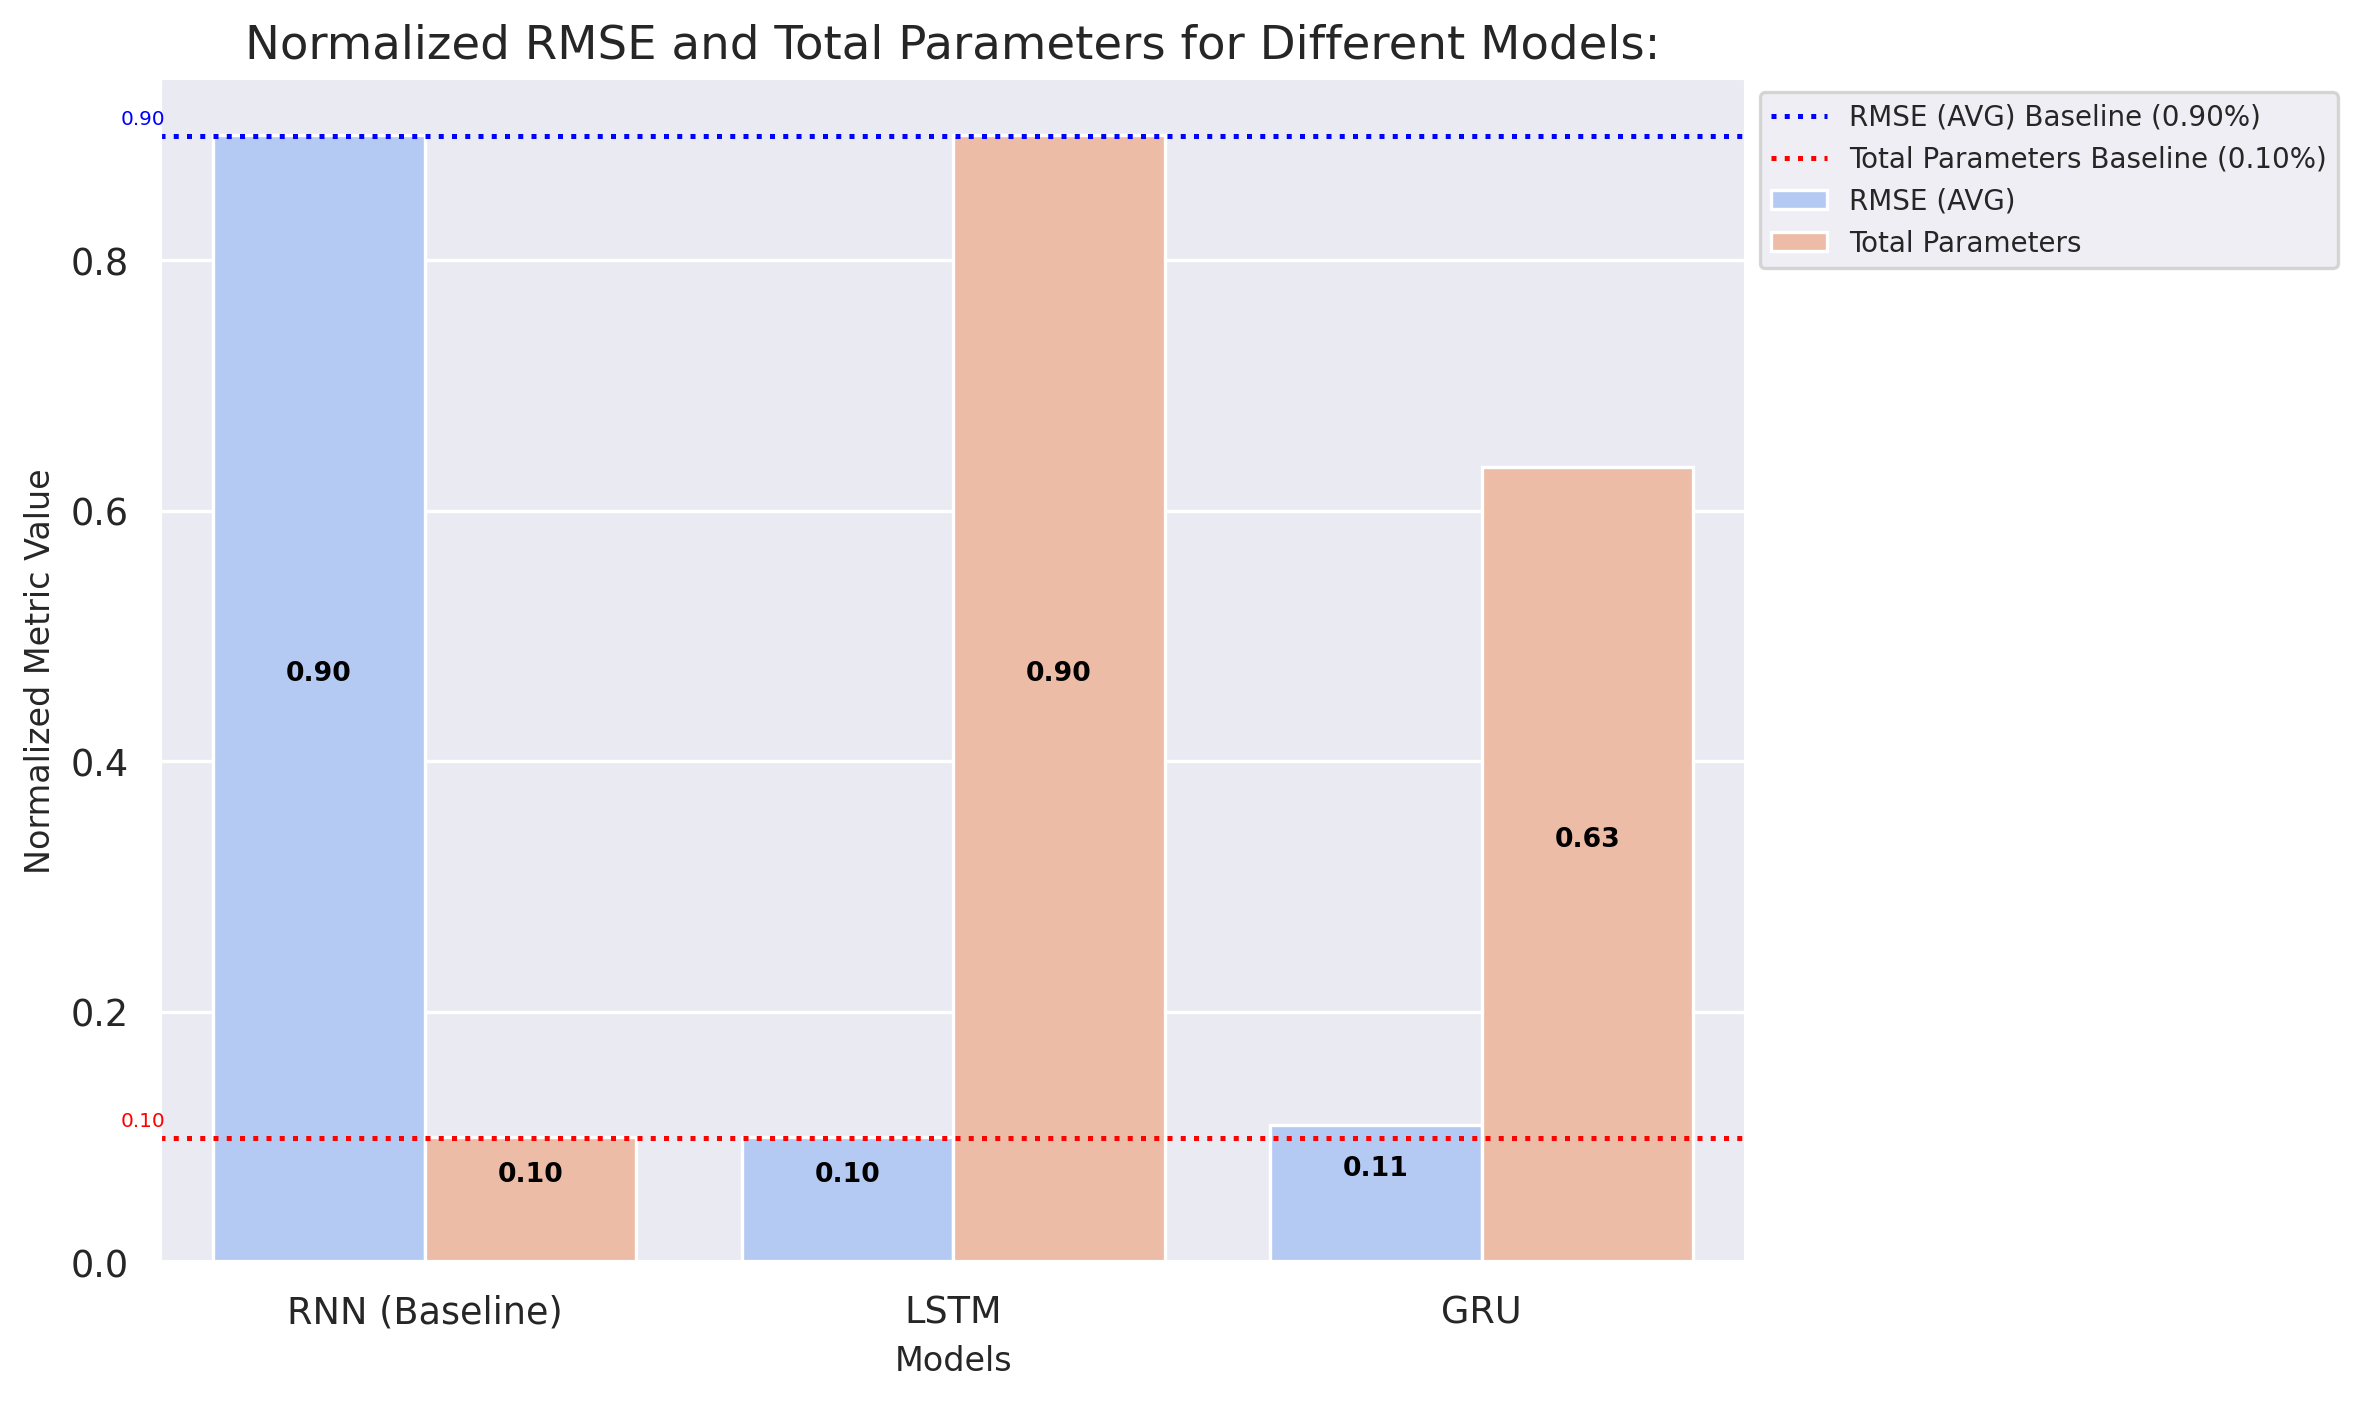

In [28]:
# Set the style
sns.set(style='darkgrid')

# Melt the dataframe
metrics_melted = pd.melt(metrics_df_comp,
                         id_vars='Model',
                         value_vars=['RMSE (AVG)', 'Total Parameters'],
                         var_name='Metric',
                         value_name='Value')

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Model',
                 y='Value',
                 hue='Metric',
                 data=metrics_melted,
                 palette='coolwarm')

# Add dotted lines for the Baseline values
plt.axhline(y=0.899,
            linestyle='dotted',
            color='blue',
            label='RMSE (AVG) Baseline (0.90%)')

plt.axhline(y=0.099,
            linestyle='dotted',
            color='red',
            label='Total Parameters Baseline (0.10%)')

# Set the labels for the x-axis
plt.xlabel('Models', fontsize=10)

# Set the labels for the y-axis
plt.ylabel('Normalized Metric Value', fontsize=10)

# Set the title for the plot
plt.title('Normalized RMSE and Total Parameters for Different Models:',
          fontsize=14)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left',
           fontsize='x-small')

# Add annotations to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2, height/2+0.02),
                ha='center',
                va='center',
                fontsize=8,
                fontweight='bold',
                color='black')

# Add text annotations for the threshold values on the y-axis
plt.text(-0.49, 0.908, '0.90', fontsize=6, color='blue', ha='right')
plt.text(-0.49, 0.108, '0.10', fontsize=6, color='red', ha='right')

# Show the plot
plt.tight_layout()
plt.show()